In [1]:
from keras.utils import to_categorical
from keras.optimizers import Adam, Adadelta, SGD
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten, Conv1D, GlobalAveragePooling1D, Convolution1D
from keras.layers.convolutional import MaxPooling2D, MaxPooling1D
from keras.models import load_model
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import class_weight
from scipy import signal
from glob import glob
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

c:\users\sebastiaan\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# constants:
SUBSAMPLE = 10  # scales the data by this factor
COLUMNS = ['HandStart', 'FirstDigitTouch',
        'BothStartLoadPhase', 'LiftOff',
        'Replace', 'BothReleased']
TRAIN_SUBJECTS = range(1, 9)
TEST_SUBJECTS = range(9, 13)
N_LABELS = 6

# Below are the paths to the data. Please pay attention to the % and * signs, these are needed in the loop.
TRAIN_DATA_PATH = 'C:/Users/Sebastiaan/Desktop/Programming/MachineLearning/Datasets/EEG/train/subj%d_series*_data.csv'
# TRAIN_DATA_PATH = 'C:/Users/bas/Documents/MachineLearning/train/subj%d_series*_data.csv'

EPOCHS = 200
WINDOW_SIZE = 2000
SPLIT_SIZE = 50
BATCH_SIZE = 10

In [3]:
def prepare_training_data(data_path):
    data = pd.read_csv(data_path)
    event_path = data_path.replace('_data', '_events')
    labels = pd.read_csv(event_path)
    clean_data = data.drop(['id'], axis = 1)
    labels = labels.drop(['id'], axis = 1)
    return clean_data, labels

In [4]:
def preprocess_data(x_raw, WINDOW_SIZE, subsample):
    x_raw, scaler = scaler_transform(x_raw[::subsample], None)
    x_raw = image_mappping(x_raw, WINDOW_SIZE)
    return x_raw, scaler

In [5]:
def scaler_transform(data, scaler):
    if scaler == None:
        scaler = Normalizer()
        return scaler.fit_transform(data), scaler
    else:
        return scaler.transform(data)   

In [6]:
def read_training_data(train_data_paths):
    labels_raw = []
    features_raw = []
    for data_path in train_data_paths:
        data, labels = prepare_training_data(data_path)
        features_raw.append(data)
        labels_raw.append(labels)
    features_raw = pd.concat(features_raw)
    labels_raw = pd.concat(labels_raw)
    x_train = np.asarray(features_raw.astype(float))
    y_train = np.asarray(labels_raw.astype(float))
    return x_train, y_train

In [7]:
def metric_auc_score(predictions, y_test, with_plot):
    scores = []
    legend_text = []
    for i in range(N_LABELS):
        fpr, tpr, _  = roc_curve(y_test[:,i], predictions[:,i], 1)
        scores.append(roc_auc_score(y_test[:,i], predictions[:,i]))
        legend_text.append(COLUMNS[i]+' (area = %.3f)' % (scores[i]))
        if with_plot == True:
            plt.plot(fpr, tpr)
    if with_plot == True:
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(legend_text)
        plt.show()
    return scores

In [8]:
def multiple_metric_auc_score(prediction_total, test_data_total, with_plot):
    legend_text = []
    counter = 0
    for i in range(len(prediction_total)):
        fpr, tpr, _  = roc_curve(test_data_total[i], prediction_total[i], pos_label=1)
        score = roc_auc_score(test_data_total[i],prediction_total[i])
        legend_text.append(COLUMNS[i]+' (area = %.3f)' % (score))
        print(COLUMNS[i]+' AUC score = %.3f' % (score))
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(legend_text)
    plt.show()

In [9]:
def single_metric_auc_score(predictions, y_test, with_plot, i):
    fpr, tpr, _  = roc_curve(y_test, predictions, 1)
    score = roc_auc_score(y_test, predictions)
    print(COLUMNS[i]+' AUC score = %.3f' % (score))
    if with_plot == True:
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.show()
    return score

In [10]:
def all_auc_scores(prediction_total, test_data_total, subjects, with_plot):
    scores = []
    for subject in subjects:
        score = metric_auc_score(prediction_total[subject-1],
                                 test_data_total[subject-1], with_plot)
        scores.append(score)
        print('Mean AUC Score of Subject %d: %.3f' % \
              (subject, np.mean(score)))
    return scores

In [11]:
def image_mappping(x_train, WINDOW_SIZE):
    result = []
    empty_matrix = np.zeros(np.shape(x_train[0:WINDOW_SIZE]))
    for i in range(len(x_train)):
        if i-WINDOW_SIZE < 0:
            result.append(empty_matrix)
        else:
            result.append(x_train[i-WINDOW_SIZE:i])
    return result

In [12]:
def resample_and_shuffle(labels):
    when_task = np.where(labels == 1)
    when_no_task = np.where(labels == 0)
    when_no_task = when_no_task[0][0:len(when_task[0])]
    indices = np.concatenate([when_task[0], when_no_task])
    np.random.shuffle(indices)
    return indices

In [13]:
def balance_set(indices, x_train, y_train):
    balance_x = []
    balance_y = []
    for index in indices:
        balance_x.append(x_train[index])
        balance_y.append(y_train[index])
    return np.array(balance_x), np.array(balance_y)

In [14]:
def remove_imbalance(x_train, y_train):
    indices = resample_and_shuffle(y_train)
    balanced_x_train, balanced_y_train = balance_set(indices, x_train, y_train)
    return balanced_x_train, balanced_y_train

In [15]:
def predict_on_sub(x_test, model, split_size, batch_size):
    split_size = int(len(x_test) / split_size)
    sub_x_test = x_test[1000::batch_size]
    batch = []
    predictions = np.array([])
    for i in range(len(sub_x_test)):
        batch.append(sub_x_test[i])
        if i+1 == len(sub_x_test):
            return np.concatenate([predictions, model.predict(np.array(batch))[:,1]])
        elif (i+1) % split_size == 0:
            predictions = np.concatenate([predictions, model.predict(np.array(batch))[:,1]])
            batch = []

In [16]:
def init_cnn(window):
    model = Sequential()
    model.add(Conv1D(nb_filter=16, filter_length=3, activation='relu', input_shape=(window, 32)))
    model.add(MaxPooling1D(3,2))
    model.add(Conv1D(nb_filter=32, filter_length=3, activation='relu'))
    model.add(Conv1D(nb_filter=64, filter_length=3, activation='relu'))
    model.add(MaxPooling1D(3,2))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))
#     model.summary()
    
    optimizer = SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
#     optimizer = Adam(lr=1e-6)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [17]:
prediction_total = []
test_data_total = []

models = []
for i in range(N_LABELS):
    models.append(init_cnn(WINDOW_SIZE))

for subject in TRAIN_SUBJECTS:
    test_features_raw = []
    train_data_paths = glob(TRAIN_DATA_PATH % (subject))

    
    x_raw, y_raw = read_training_data(train_data_paths)
    
    x_raw, _ = preprocess_data(x_raw, WINDOW_SIZE, SUBSAMPLE)
#     y_train = y_raw[::SUBSAMPLE]
    x_train, _, y_train, _ = train_test_split(x_raw, y_raw[::SUBSAMPLE], test_size=0.5)

    
    for i in range(N_LABELS):
        model = models[i]
        
        balanced_x_train, balanced_y_train = remove_imbalance(x_train, y_train[:,i])
        
        train_labels = to_categorical(balanced_y_train, num_classes = None)
                
        print('Train subject %d, class %s' % (subject, COLUMNS[i]))        
        model.fit(balanced_x_train, train_labels, verbose=1, validation_split=0.2, epochs=EPOCHS)
    
    
    for task_name, model in zip(COLUMNS, models):
        model.save('general_model_'+task_name+'_subject_%d.h5' % (subject))  # creates a HDF5 file 'my_model.h5'
#         predictions = predict_on_sub(x_test, model, SPLIT_SIZE, BATCH_SIZE)
        
#         test_data_total.append(y_test[:,i][1000::BATCH_SIZE])
#         prediction_total.append(predictions)
        
#     multiple_metric_auc_score(prediction_total, test_data_total, True)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Train subject 1, class HandStart
Train on 3088 samples, validate on 772 samples
Epoch 1/200
3088/3088 [==============================] - 10s 3ms/step - loss: 0.6932 - acc: 0.4977 - val_loss: 0.6953 - val_acc: 0.4547
Epoch 2/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.6929 - acc: 0.5081 - val_loss: 0.6954 - val_acc: 0.4534
Epoch 3/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.6921 - acc: 0.5126 - val_loss: 0.6953 - val_acc: 0.4534
Epoch 4/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.6919 - acc: 0.5094 - val_loss: 0.6952 - val_acc: 0.4521
Epoch 5/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.6910 - acc: 0.5204 - val_loss: 0.6938 - val_acc: 0.4598
Epoch 6/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.6899 - acc: 0.5359 - val_loss: 0.6937 - val_acc: 0.4585
Epoch 7/200
3088/3088 [===

3088/3088 [==============================] - 5s 2ms/step - loss: 0.4307 - acc: 0.8025 - val_loss: 0.4803 - val_acc: 0.7953
Epoch 59/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.4241 - acc: 0.8080 - val_loss: 0.4822 - val_acc: 0.7759
Epoch 60/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.4208 - acc: 0.8106 - val_loss: 0.4779 - val_acc: 0.7889
Epoch 61/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.4186 - acc: 0.8106 - val_loss: 0.4794 - val_acc: 0.7850
Epoch 62/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.4173 - acc: 0.8096 - val_loss: 0.4774 - val_acc: 0.7876
Epoch 63/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.4134 - acc: 0.8138 - val_loss: 0.4699 - val_acc: 0.8018
Epoch 64/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.4090 - acc: 0.8177 - val_loss: 0.4734 - val_acc: 0.7915
Epoch 65/200
3088/3088 [==============================] - 5s 

3088/3088 [==============================] - 5s 2ms/step - loss: 0.3105 - acc: 0.8756 - val_loss: 0.3852 - val_acc: 0.8484
Epoch 119/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.3112 - acc: 0.8812 - val_loss: 0.3831 - val_acc: 0.8484
Epoch 120/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.3055 - acc: 0.8844 - val_loss: 0.3813 - val_acc: 0.8459
Epoch 121/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.3054 - acc: 0.8818 - val_loss: 0.3799 - val_acc: 0.8497
Epoch 122/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.3050 - acc: 0.8795 - val_loss: 0.3802 - val_acc: 0.8497
Epoch 123/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.3047 - acc: 0.8831 - val_loss: 0.3773 - val_acc: 0.8523
Epoch 124/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.3116 - acc: 0.8776 - val_loss: 0.3738 - val_acc: 0.8472
Epoch 125/200
3088/3088 [==============================

Epoch 178/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.2332 - acc: 0.9113 - val_loss: 0.2966 - val_acc: 0.8899
Epoch 179/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.2256 - acc: 0.9129 - val_loss: 0.2991 - val_acc: 0.8860
Epoch 180/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.2290 - acc: 0.9148 - val_loss: 0.2943 - val_acc: 0.8938
Epoch 181/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.2244 - acc: 0.9126 - val_loss: 0.2959 - val_acc: 0.8886 0s - loss: 0.2237 - acc: 0.912
Epoch 182/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.2287 - acc: 0.9139 - val_loss: 0.2901 - val_acc: 0.8951
Epoch 183/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.2238 - acc: 0.9171 - val_loss: 0.2907 - val_acc: 0.8951
Epoch 184/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.2216 - acc: 0.9174 - val_loss: 0.2895 - val_acc: 0.8899
Epoch 185/

3123/3123 [==============================] - 5s 2ms/step - loss: 0.4676 - acc: 0.7903 - val_loss: 0.4679 - val_acc: 0.8092
Epoch 38/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.4623 - acc: 0.7999 - val_loss: 0.4626 - val_acc: 0.8131
Epoch 39/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.4596 - acc: 0.7947 - val_loss: 0.4587 - val_acc: 0.8131
Epoch 40/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.4524 - acc: 0.8021 - val_loss: 0.4586 - val_acc: 0.8105
Epoch 41/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.4484 - acc: 0.8076 - val_loss: 0.4519 - val_acc: 0.8207
Epoch 42/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.4444 - acc: 0.8088 - val_loss: 0.4475 - val_acc: 0.8143
Epoch 43/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.4403 - acc: 0.8146 - val_loss: 0.4408 - val_acc: 0.8207
Epoch 44/200
3123/3123 [==============================] - 5s 

3123/3123 [==============================] - 5s 2ms/step - loss: 0.2256 - acc: 0.9190 - val_loss: 0.2373 - val_acc: 0.9142
Epoch 98/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.2373 - acc: 0.9139 - val_loss: 0.2482 - val_acc: 0.9168
Epoch 99/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.2251 - acc: 0.9145 - val_loss: 0.2459 - val_acc: 0.9181
Epoch 100/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.2179 - acc: 0.9196 - val_loss: 0.2322 - val_acc: 0.9129
Epoch 101/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.2244 - acc: 0.9148 - val_loss: 0.2379 - val_acc: 0.9232
Epoch 102/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.2195 - acc: 0.9132 - val_loss: 0.2463 - val_acc: 0.9181
Epoch 103/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.2195 - acc: 0.9180 - val_loss: 0.2390 - val_acc: 0.9232
Epoch 104/200
3123/3123 [==============================] 

Epoch 157/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.1511 - acc: 0.9488 - val_loss: 0.1968 - val_acc: 0.9360
Epoch 158/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.1484 - acc: 0.9491 - val_loss: 0.2414 - val_acc: 0.9193
Epoch 159/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.1524 - acc: 0.9443 - val_loss: 0.2148 - val_acc: 0.9283
Epoch 160/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.1531 - acc: 0.9376 - val_loss: 0.2182 - val_acc: 0.9270
Epoch 161/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.1477 - acc: 0.9452 - val_loss: 0.1945 - val_acc: 0.9347
Epoch 162/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.1497 - acc: 0.9468 - val_loss: 0.1839 - val_acc: 0.9373
Epoch 163/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.1481 - acc: 0.9430 - val_loss: 0.1838 - val_acc: 0.9373loss: 0.1485 - acc: 
Epoch 164/200
3123/31

3156/3156 [==============================] - 5s 2ms/step - loss: 0.6519 - acc: 0.6543 - val_loss: 0.6445 - val_acc: 0.6911
Epoch 17/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.6447 - acc: 0.6603 - val_loss: 0.6385 - val_acc: 0.6873
Epoch 18/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.6374 - acc: 0.6721 - val_loss: 0.6307 - val_acc: 0.6962
Epoch 19/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.6329 - acc: 0.6733 - val_loss: 0.6235 - val_acc: 0.7063
Epoch 20/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.6206 - acc: 0.6898 - val_loss: 0.6165 - val_acc: 0.6937
Epoch 21/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.6148 - acc: 0.6901 - val_loss: 0.6081 - val_acc: 0.7215
Epoch 22/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.6068 - acc: 0.6952 - val_loss: 0.6034 - val_acc: 0.6987
Epoch 23/200
3156/3156 [==============================] - 5s 

3156/3156 [==============================] - 5s 2ms/step - loss: 0.2476 - acc: 0.8970 - val_loss: 0.3368 - val_acc: 0.8696
Epoch 77/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.2606 - acc: 0.8986 - val_loss: 0.2773 - val_acc: 0.9038
Epoch 78/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.2514 - acc: 0.9002 - val_loss: 0.2920 - val_acc: 0.8924
Epoch 79/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.2402 - acc: 0.9075 - val_loss: 0.3082 - val_acc: 0.8848
Epoch 80/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.2463 - acc: 0.8986 - val_loss: 0.2982 - val_acc: 0.8911
Epoch 81/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.2370 - acc: 0.9065 - val_loss: 0.2943 - val_acc: 0.8924
Epoch 82/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.2371 - acc: 0.9021 - val_loss: 0.2650 - val_acc: 0.9127
Epoch 83/200
3156/3156 [==============================] - 5s 

3156/3156 [==============================] - 5s 2ms/step - loss: 0.1619 - acc: 0.9385 - val_loss: 0.2689 - val_acc: 0.9063
Epoch 137/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.1575 - acc: 0.9417 - val_loss: 0.2166 - val_acc: 0.9291
Epoch 138/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.1598 - acc: 0.9376 - val_loss: 0.2439 - val_acc: 0.9101
Epoch 139/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.1599 - acc: 0.9417 - val_loss: 0.2074 - val_acc: 0.9329
Epoch 140/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.1654 - acc: 0.9366 - val_loss: 0.2531 - val_acc: 0.9076
Epoch 141/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.1577 - acc: 0.9398 - val_loss: 0.2451 - val_acc: 0.9114
Epoch 142/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.1531 - acc: 0.9442 - val_loss: 0.2266 - val_acc: 0.9291
Epoch 143/200
3156/3156 [==============================

Epoch 196/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.1195 - acc: 0.9572 - val_loss: 0.1953 - val_acc: 0.9380
Epoch 197/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.1220 - acc: 0.9518 - val_loss: 0.1921 - val_acc: 0.9380
Epoch 198/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.1154 - acc: 0.9579 - val_loss: 0.1867 - val_acc: 0.9418
Epoch 199/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.1169 - acc: 0.9588 - val_loss: 0.2021 - val_acc: 0.9367
Epoch 200/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.1154 - acc: 0.9544 - val_loss: 0.2326 - val_acc: 0.9228
Train subject 1, class LiftOff
Train on 3092 samples, validate on 774 samples
Epoch 1/200
3092/3092 [==============================] - 6s 2ms/step - loss: 0.6944 - acc: 0.5052 - val_loss: 0.6923 - val_acc: 0.5271
Epoch 2/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.6930 - acc: 0.5100 - va

Epoch 56/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.2828 - acc: 0.8868 - val_loss: 0.3130 - val_acc: 0.8863
Epoch 57/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.2934 - acc: 0.8852 - val_loss: 0.3101 - val_acc: 0.8824
Epoch 58/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.2748 - acc: 0.8920 - val_loss: 0.3322 - val_acc: 0.8786
Epoch 59/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.2742 - acc: 0.8887 - val_loss: 0.3060 - val_acc: 0.8953
Epoch 60/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.2723 - acc: 0.8913 - val_loss: 0.3248 - val_acc: 0.8824
Epoch 61/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.2698 - acc: 0.8929 - val_loss: 0.3226 - val_acc: 0.8850
Epoch 62/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.2682 - acc: 0.8923 - val_loss: 0.3021 - val_acc: 0.8966
Epoch 63/200
3092/3092 [========================

3092/3092 [==============================] - 5s 2ms/step - loss: 0.1945 - acc: 0.9214 - val_loss: 0.2626 - val_acc: 0.9147
Epoch 117/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1889 - acc: 0.9256 - val_loss: 0.2549 - val_acc: 0.9134
Epoch 118/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1931 - acc: 0.9292 - val_loss: 0.2902 - val_acc: 0.8966
Epoch 119/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1905 - acc: 0.9272 - val_loss: 0.2444 - val_acc: 0.9238
Epoch 120/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1851 - acc: 0.9285 - val_loss: 0.2515 - val_acc: 0.9134
Epoch 121/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1901 - acc: 0.9298 - val_loss: 0.2528 - val_acc: 0.9147
Epoch 122/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1834 - acc: 0.9311 - val_loss: 0.2465 - val_acc: 0.9199
Epoch 123/200
3092/3092 [==============================

3092/3092 [==============================] - 5s 2ms/step - loss: 0.1516 - acc: 0.9424 - val_loss: 0.2346 - val_acc: 0.9264
Epoch 176/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1404 - acc: 0.9476 - val_loss: 0.2652 - val_acc: 0.9134
Epoch 177/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1477 - acc: 0.9457 - val_loss: 0.2240 - val_acc: 0.9341
Epoch 178/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1406 - acc: 0.9447 - val_loss: 0.2318 - val_acc: 0.9289
Epoch 179/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1437 - acc: 0.9460 - val_loss: 0.2177 - val_acc: 0.9367
Epoch 180/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1389 - acc: 0.9515 - val_loss: 0.2183 - val_acc: 0.9380
Epoch 181/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1382 - acc: 0.9518 - val_loss: 0.2173 - val_acc: 0.9367
Epoch 182/200
3092/3092 [==============================

3142/3142 [==============================] - 5s 2ms/step - loss: 0.4275 - acc: 0.8211 - val_loss: 0.3986 - val_acc: 0.8511
Epoch 35/200
3142/3142 [==============================] - 5s 2ms/step - loss: 0.4193 - acc: 0.8275 - val_loss: 0.3857 - val_acc: 0.8499
Epoch 36/200
3142/3142 [==============================] - 5s 2ms/step - loss: 0.4066 - acc: 0.8272 - val_loss: 0.3746 - val_acc: 0.8537
Epoch 37/200
3142/3142 [==============================] - 5s 2ms/step - loss: 0.3917 - acc: 0.8374 - val_loss: 0.3648 - val_acc: 0.8562
Epoch 38/200
3142/3142 [==============================] - 5s 2ms/step - loss: 0.3769 - acc: 0.8466 - val_loss: 0.3440 - val_acc: 0.8753
Epoch 39/200
3142/3142 [==============================] - 5s 2ms/step - loss: 0.3652 - acc: 0.8523 - val_loss: 0.3549 - val_acc: 0.8575
Epoch 40/200
3142/3142 [==============================] - 5s 2ms/step - loss: 0.3584 - acc: 0.8558 - val_loss: 0.3242 - val_acc: 0.8728
Epoch 41/200
3142/3142 [==============================] - 5s 

3142/3142 [==============================] - 5s 2ms/step - loss: 0.1723 - acc: 0.9341 - val_loss: 0.1688 - val_acc: 0.9389
Epoch 95/200
3142/3142 [==============================] - 5s 2ms/step - loss: 0.1692 - acc: 0.9386 - val_loss: 0.1613 - val_acc: 0.9377
Epoch 96/200
3142/3142 [==============================] - 5s 2ms/step - loss: 0.1660 - acc: 0.9402 - val_loss: 0.1566 - val_acc: 0.9415
Epoch 97/200
3142/3142 [==============================] - 5s 2ms/step - loss: 0.1634 - acc: 0.9421 - val_loss: 0.1729 - val_acc: 0.9415
Epoch 98/200
3142/3142 [==============================] - 5s 2ms/step - loss: 0.1640 - acc: 0.9389 - val_loss: 0.1548 - val_acc: 0.9389
Epoch 99/200
3142/3142 [==============================] - 5s 2ms/step - loss: 0.1683 - acc: 0.9373 - val_loss: 0.1561 - val_acc: 0.9389
Epoch 100/200
3142/3142 [==============================] - 5s 2ms/step - loss: 0.1690 - acc: 0.9376 - val_loss: 0.1906 - val_acc: 0.9313
Epoch 101/200
3142/3142 [==============================] - 5

Epoch 154/200
3142/3142 [==============================] - 5s 2ms/step - loss: 0.1118 - acc: 0.9577 - val_loss: 0.1273 - val_acc: 0.9593
Epoch 155/200
3142/3142 [==============================] - 5s 2ms/step - loss: 0.1152 - acc: 0.9570 - val_loss: 0.1211 - val_acc: 0.9453
Epoch 156/200
3142/3142 [==============================] - 5s 2ms/step - loss: 0.1129 - acc: 0.9564 - val_loss: 0.1238 - val_acc: 0.9618
Epoch 157/200
3142/3142 [==============================] - 5s 2ms/step - loss: 0.1216 - acc: 0.9535 - val_loss: 0.1248 - val_acc: 0.9427
Epoch 158/200
3142/3142 [==============================] - 5s 2ms/step - loss: 0.1187 - acc: 0.9558 - val_loss: 0.1373 - val_acc: 0.9517
Epoch 159/200
3142/3142 [==============================] - 5s 2ms/step - loss: 0.1097 - acc: 0.9577 - val_loss: 0.1537 - val_acc: 0.9466
Epoch 160/200
3142/3142 [==============================] - 5s 2ms/step - loss: 0.1198 - acc: 0.9567 - val_loss: 0.1584 - val_acc: 0.9453
Epoch 161/200
3142/3142 [================

3120/3120 [==============================] - 5s 2ms/step - loss: 0.5612 - acc: 0.7673 - val_loss: 0.5147 - val_acc: 0.8115
Epoch 14/200
3120/3120 [==============================] - 5s 2ms/step - loss: 0.5357 - acc: 0.7654 - val_loss: 0.4858 - val_acc: 0.8090
Epoch 15/200
3120/3120 [==============================] - 5s 2ms/step - loss: 0.5082 - acc: 0.7776 - val_loss: 0.4591 - val_acc: 0.8128
Epoch 16/200
3120/3120 [==============================] - 5s 2ms/step - loss: 0.4844 - acc: 0.7849 - val_loss: 0.4384 - val_acc: 0.8218
Epoch 17/200
3120/3120 [==============================] - 5s 2ms/step - loss: 0.4640 - acc: 0.7974 - val_loss: 0.4155 - val_acc: 0.8308
Epoch 18/200
3120/3120 [==============================] - 5s 2ms/step - loss: 0.4439 - acc: 0.8051 - val_loss: 0.4046 - val_acc: 0.8397
Epoch 19/200
3120/3120 [==============================] - 5s 2ms/step - loss: 0.4323 - acc: 0.8112 - val_loss: 0.3850 - val_acc: 0.8449
Epoch 20/200
3120/3120 [==============================] - 5s 

3120/3120 [==============================] - 5s 2ms/step - loss: 0.2139 - acc: 0.9199 - val_loss: 0.2197 - val_acc: 0.9154
Epoch 74/200
3120/3120 [==============================] - 5s 2ms/step - loss: 0.2177 - acc: 0.9199 - val_loss: 0.2070 - val_acc: 0.9321
Epoch 75/200
3120/3120 [==============================] - 5s 2ms/step - loss: 0.2150 - acc: 0.9215 - val_loss: 0.2635 - val_acc: 0.9051
Epoch 76/200
3120/3120 [==============================] - 5s 2ms/step - loss: 0.2187 - acc: 0.9170 - val_loss: 0.2338 - val_acc: 0.9141
Epoch 77/200
3120/3120 [==============================] - 5s 2ms/step - loss: 0.2186 - acc: 0.9218 - val_loss: 0.2077 - val_acc: 0.9269
Epoch 78/200
3120/3120 [==============================] - 5s 2ms/step - loss: 0.2158 - acc: 0.9160 - val_loss: 0.2203 - val_acc: 0.9179
Epoch 79/200
3120/3120 [==============================] - 5s 2ms/step - loss: 0.2122 - acc: 0.9176 - val_loss: 0.2094 - val_acc: 0.9244
Epoch 80/200
3120/3120 [==============================] - 5s 

3120/3120 [==============================] - 5s 2ms/step - loss: 0.1669 - acc: 0.9388 - val_loss: 0.1712 - val_acc: 0.9462
Epoch 134/200
3120/3120 [==============================] - 5s 2ms/step - loss: 0.1613 - acc: 0.9442 - val_loss: 0.1797 - val_acc: 0.9410
Epoch 135/200
3120/3120 [==============================] - 5s 2ms/step - loss: 0.1622 - acc: 0.9378 - val_loss: 0.1832 - val_acc: 0.9385
Epoch 136/200
3120/3120 [==============================] - 5s 2ms/step - loss: 0.1676 - acc: 0.9388 - val_loss: 0.1735 - val_acc: 0.9436
Epoch 137/200
3120/3120 [==============================] - 5s 2ms/step - loss: 0.1612 - acc: 0.9404 - val_loss: 0.1706 - val_acc: 0.9474
Epoch 138/200
3120/3120 [==============================] - 5s 2ms/step - loss: 0.1671 - acc: 0.9391 - val_loss: 0.1727 - val_acc: 0.9449
Epoch 139/200
3120/3120 [==============================] - 5s 2ms/step - loss: 0.1585 - acc: 0.9372 - val_loss: 0.1757 - val_acc: 0.9423
Epoch 140/200
3120/3120 [==============================

Epoch 193/200
3120/3120 [==============================] - 5s 2ms/step - loss: 0.1334 - acc: 0.9529 - val_loss: 0.1650 - val_acc: 0.9474
Epoch 194/200
3120/3120 [==============================] - 5s 2ms/step - loss: 0.1274 - acc: 0.9529 - val_loss: 0.1593 - val_acc: 0.9487
Epoch 195/200
3120/3120 [==============================] - 5s 2ms/step - loss: 0.1309 - acc: 0.9513 - val_loss: 0.1495 - val_acc: 0.9538
Epoch 196/200
3120/3120 [==============================] - 5s 2ms/step - loss: 0.1292 - acc: 0.9510 - val_loss: 0.1783 - val_acc: 0.9474
Epoch 197/200
3120/3120 [==============================] - 5s 2ms/step - loss: 0.1304 - acc: 0.9548 - val_loss: 0.1559 - val_acc: 0.9538
Epoch 198/200
3120/3120 [==============================] - 5s 2ms/step - loss: 0.1345 - acc: 0.9490 - val_loss: 0.1522 - val_acc: 0.9538
Epoch 199/200
3120/3120 [==============================] - 5s 2ms/step - loss: 0.1315 - acc: 0.9516 - val_loss: 0.1721 - val_acc: 0.9474
Epoch 200/200
3120/3120 [================

3067/3067 [==============================] - 5s 2ms/step - loss: 0.3536 - acc: 0.8471 - val_loss: 0.4617 - val_acc: 0.8188
Epoch 53/200
3067/3067 [==============================] - 5s 2ms/step - loss: 0.3561 - acc: 0.8487 - val_loss: 0.4302 - val_acc: 0.8070
Epoch 54/200
3067/3067 [==============================] - 5s 2ms/step - loss: 0.3483 - acc: 0.8520 - val_loss: 0.4278 - val_acc: 0.8149
Epoch 55/200
3067/3067 [==============================] - 5s 2ms/step - loss: 0.3476 - acc: 0.8520 - val_loss: 0.4471 - val_acc: 0.8227
Epoch 56/200
3067/3067 [==============================] - 5s 2ms/step - loss: 0.3473 - acc: 0.8510 - val_loss: 0.4294 - val_acc: 0.8149
Epoch 57/200
3067/3067 [==============================] - 5s 2ms/step - loss: 0.3359 - acc: 0.8582 - val_loss: 0.4438 - val_acc: 0.8240
Epoch 58/200
3067/3067 [==============================] - 5s 2ms/step - loss: 0.3385 - acc: 0.8562 - val_loss: 0.4271 - val_acc: 0.8201
Epoch 59/200
3067/3067 [==============================] - 5s 

3067/3067 [==============================] - 5s 2ms/step - loss: 0.2270 - acc: 0.9149 - val_loss: 0.3422 - val_acc: 0.8761
Epoch 113/200
3067/3067 [==============================] - 5s 2ms/step - loss: 0.2330 - acc: 0.9142 - val_loss: 0.3322 - val_acc: 0.8814
Epoch 114/200
3067/3067 [==============================] - 5s 2ms/step - loss: 0.2292 - acc: 0.9094 - val_loss: 0.3443 - val_acc: 0.8696
Epoch 115/200
3067/3067 [==============================] - 5s 2ms/step - loss: 0.2283 - acc: 0.9110 - val_loss: 0.3248 - val_acc: 0.8840
Epoch 116/200
3067/3067 [==============================] - 5s 2ms/step - loss: 0.2209 - acc: 0.9146 - val_loss: 0.3365 - val_acc: 0.8787
Epoch 117/200
3067/3067 [==============================] - 5s 2ms/step - loss: 0.2263 - acc: 0.9156 - val_loss: 0.3453 - val_acc: 0.8670
Epoch 118/200
3067/3067 [==============================] - 5s 2ms/step - loss: 0.2267 - acc: 0.9139 - val_loss: 0.3275 - val_acc: 0.8853
Epoch 119/200
3067/3067 [==============================

Epoch 172/200
3067/3067 [==============================] - 5s 2ms/step - loss: 0.1506 - acc: 0.9449 - val_loss: 0.2870 - val_acc: 0.9087
Epoch 173/200
3067/3067 [==============================] - 5s 2ms/step - loss: 0.1550 - acc: 0.9423 - val_loss: 0.3344 - val_acc: 0.8892
Epoch 174/200
3067/3067 [==============================] - 5s 2ms/step - loss: 0.1569 - acc: 0.9413 - val_loss: 0.2986 - val_acc: 0.9061
Epoch 175/200
3067/3067 [==============================] - 5s 2ms/step - loss: 0.1423 - acc: 0.9501 - val_loss: 0.3113 - val_acc: 0.8983
Epoch 176/200
3067/3067 [==============================] - 5s 2ms/step - loss: 0.1535 - acc: 0.9442 - val_loss: 0.2999 - val_acc: 0.9022
Epoch 177/200
3067/3067 [==============================] - 5s 2ms/step - loss: 0.1438 - acc: 0.9459 - val_loss: 0.3129 - val_acc: 0.8983
Epoch 178/200
3067/3067 [==============================] - 5s 2ms/step - loss: 0.1498 - acc: 0.9442 - val_loss: 0.2826 - val_acc: 0.9087
Epoch 179/200
3067/3067 [================

3112/3112 [==============================] - 5s 2ms/step - loss: 0.3040 - acc: 0.8650 - val_loss: 0.3307 - val_acc: 0.8895
Epoch 32/200
3112/3112 [==============================] - 5s 2ms/step - loss: 0.2975 - acc: 0.8679 - val_loss: 0.3362 - val_acc: 0.8830
Epoch 33/200
3112/3112 [==============================] - 5s 2ms/step - loss: 0.2965 - acc: 0.8721 - val_loss: 0.3651 - val_acc: 0.8650
Epoch 34/200
3112/3112 [==============================] - 5s 2ms/step - loss: 0.2972 - acc: 0.8641 - val_loss: 0.3252 - val_acc: 0.8933
Epoch 35/200
3112/3112 [==============================] - 5s 2ms/step - loss: 0.3004 - acc: 0.8686 - val_loss: 0.3195 - val_acc: 0.8946
Epoch 36/200
3112/3112 [==============================] - 5s 2ms/step - loss: 0.2899 - acc: 0.8766 - val_loss: 0.3258 - val_acc: 0.8933
Epoch 37/200
3112/3112 [==============================] - 5s 2ms/step - loss: 0.2876 - acc: 0.8699 - val_loss: 0.3218 - val_acc: 0.8972
Epoch 38/200
3112/3112 [==============================] - 5s 

3112/3112 [==============================] - 5s 2ms/step - loss: 0.1828 - acc: 0.9287 - val_loss: 0.2452 - val_acc: 0.9177
Epoch 92/200
3112/3112 [==============================] - 5s 2ms/step - loss: 0.1856 - acc: 0.9299 - val_loss: 0.2479 - val_acc: 0.9152
Epoch 93/200
3112/3112 [==============================] - 5s 2ms/step - loss: 0.1827 - acc: 0.9306 - val_loss: 0.2618 - val_acc: 0.9165
Epoch 94/200
3112/3112 [==============================] - 5s 2ms/step - loss: 0.1809 - acc: 0.9303 - val_loss: 0.2504 - val_acc: 0.9190
Epoch 95/200
3112/3112 [==============================] - 5s 2ms/step - loss: 0.1869 - acc: 0.9235 - val_loss: 0.2533 - val_acc: 0.9177
Epoch 96/200
3112/3112 [==============================] - 5s 2ms/step - loss: 0.1842 - acc: 0.9322 - val_loss: 0.2508 - val_acc: 0.9177
Epoch 97/200
3112/3112 [==============================] - 5s 2ms/step - loss: 0.1819 - acc: 0.9283 - val_loss: 0.2509 - val_acc: 0.9177
Epoch 98/200
3112/3112 [==============================] - 5s 

Epoch 151/200
3112/3112 [==============================] - 5s 2ms/step - loss: 0.1268 - acc: 0.9512 - val_loss: 0.2011 - val_acc: 0.9319
Epoch 152/200
3112/3112 [==============================] - 5s 2ms/step - loss: 0.1262 - acc: 0.9528 - val_loss: 0.2235 - val_acc: 0.9280
Epoch 153/200
3112/3112 [==============================] - 5s 2ms/step - loss: 0.1245 - acc: 0.9553 - val_loss: 0.2091 - val_acc: 0.9370
Epoch 154/200
3112/3112 [==============================] - 5s 2ms/step - loss: 0.1226 - acc: 0.9528 - val_loss: 0.2173 - val_acc: 0.9319
Epoch 155/200
3112/3112 [==============================] - 5s 2ms/step - loss: 0.1251 - acc: 0.9528 - val_loss: 0.2336 - val_acc: 0.9242
Epoch 156/200
3112/3112 [==============================] - 5s 2ms/step - loss: 0.1211 - acc: 0.9544 - val_loss: 0.2348 - val_acc: 0.9229
Epoch 157/200
3112/3112 [==============================] - 5s 2ms/step - loss: 0.1236 - acc: 0.9512 - val_loss: 0.2201 - val_acc: 0.9319
Epoch 158/200
3112/3112 [================

3092/3092 [==============================] - 5s 2ms/step - loss: 0.4671 - acc: 0.7791 - val_loss: 0.4911 - val_acc: 0.7506
Epoch 11/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.4535 - acc: 0.7878 - val_loss: 0.4653 - val_acc: 0.7661
Epoch 12/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.4480 - acc: 0.7804 - val_loss: 0.4599 - val_acc: 0.7713
Epoch 13/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.4374 - acc: 0.7959 - val_loss: 0.4659 - val_acc: 0.7700
Epoch 14/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.4357 - acc: 0.8001 - val_loss: 0.4692 - val_acc: 0.7778
Epoch 15/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.4231 - acc: 0.8027 - val_loss: 0.4364 - val_acc: 0.7778
Epoch 16/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.4160 - acc: 0.8047 - val_loss: 0.4297 - val_acc: 0.7842
Epoch 17/200
3092/3092 [==============================] - 5s 

3092/3092 [==============================] - 5s 2ms/step - loss: 0.2425 - acc: 0.9007 - val_loss: 0.3223 - val_acc: 0.8786
Epoch 71/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.2514 - acc: 0.8942 - val_loss: 0.3245 - val_acc: 0.8798
Epoch 72/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.2377 - acc: 0.9010 - val_loss: 0.3171 - val_acc: 0.8760
Epoch 73/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.2411 - acc: 0.9004 - val_loss: 0.3161 - val_acc: 0.8786
Epoch 74/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.2368 - acc: 0.9085 - val_loss: 0.3243 - val_acc: 0.8811
Epoch 75/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.2324 - acc: 0.9027 - val_loss: 0.3055 - val_acc: 0.8798
Epoch 76/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.2286 - acc: 0.9104 - val_loss: 0.3066 - val_acc: 0.8811
Epoch 77/200
3092/3092 [==============================] - 5s 

3092/3092 [==============================] - 5s 2ms/step - loss: 0.1602 - acc: 0.9392 - val_loss: 0.2814 - val_acc: 0.9018
Epoch 131/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1677 - acc: 0.9360 - val_loss: 0.2963 - val_acc: 0.9005
Epoch 132/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1683 - acc: 0.9327 - val_loss: 0.3028 - val_acc: 0.8992
Epoch 133/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1628 - acc: 0.9431 - val_loss: 0.2789 - val_acc: 0.9044
Epoch 134/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1566 - acc: 0.9457 - val_loss: 0.2911 - val_acc: 0.9018
Epoch 135/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1656 - acc: 0.9405 - val_loss: 0.2775 - val_acc: 0.9057
Epoch 136/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1600 - acc: 0.9392 - val_loss: 0.2919 - val_acc: 0.9031
Epoch 137/200
3092/3092 [==============================

Epoch 190/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1206 - acc: 0.9599 - val_loss: 0.2811 - val_acc: 0.9057
Epoch 191/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1180 - acc: 0.9602 - val_loss: 0.3040 - val_acc: 0.8979
Epoch 192/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1129 - acc: 0.9605 - val_loss: 0.2951 - val_acc: 0.9031
Epoch 193/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1164 - acc: 0.9554 - val_loss: 0.2731 - val_acc: 0.9083
Epoch 194/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1138 - acc: 0.9622 - val_loss: 0.2455 - val_acc: 0.9264
Epoch 195/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1147 - acc: 0.9563 - val_loss: 0.2980 - val_acc: 0.9057
Epoch 196/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1185 - acc: 0.9554 - val_loss: 0.2889 - val_acc: 0.9083
Epoch 197/200
3092/3092 [================

3152/3152 [==============================] - 5s 2ms/step - loss: 0.3744 - acc: 0.8442 - val_loss: 0.3741 - val_acc: 0.8464
Epoch 50/200
3152/3152 [==============================] - 5s 2ms/step - loss: 0.3701 - acc: 0.8499 - val_loss: 0.3606 - val_acc: 0.8477
Epoch 51/200
3152/3152 [==============================] - 5s 2ms/step - loss: 0.3664 - acc: 0.8464 - val_loss: 0.3600 - val_acc: 0.8452
Epoch 52/200
3152/3152 [==============================] - 5s 2ms/step - loss: 0.3682 - acc: 0.8449 - val_loss: 0.3593 - val_acc: 0.8439
Epoch 53/200
3152/3152 [==============================] - 5s 2ms/step - loss: 0.3650 - acc: 0.8528 - val_loss: 0.3623 - val_acc: 0.8553
Epoch 54/200
3152/3152 [==============================] - 5s 2ms/step - loss: 0.3605 - acc: 0.8522 - val_loss: 0.3614 - val_acc: 0.8591
Epoch 55/200
3152/3152 [==============================] - 5s 2ms/step - loss: 0.3570 - acc: 0.8550 - val_loss: 0.3576 - val_acc: 0.8528
Epoch 56/200
3152/3152 [==============================] - 5s 

3152/3152 [==============================] - 5s 2ms/step - loss: 0.2737 - acc: 0.8966 - val_loss: 0.3032 - val_acc: 0.8756
Epoch 110/200
3152/3152 [==============================] - 5s 2ms/step - loss: 0.2715 - acc: 0.8944 - val_loss: 0.3064 - val_acc: 0.8756
Epoch 111/200
3152/3152 [==============================] - 5s 2ms/step - loss: 0.2772 - acc: 0.8915 - val_loss: 0.3015 - val_acc: 0.8782
Epoch 112/200
3152/3152 [==============================] - 5s 2ms/step - loss: 0.2708 - acc: 0.8963 - val_loss: 0.3178 - val_acc: 0.8706
Epoch 113/200
3152/3152 [==============================] - 5s 2ms/step - loss: 0.2754 - acc: 0.8921 - val_loss: 0.2965 - val_acc: 0.8820
Epoch 114/200
3152/3152 [==============================] - 5s 2ms/step - loss: 0.2629 - acc: 0.8985 - val_loss: 0.2932 - val_acc: 0.8832
Epoch 115/200
3152/3152 [==============================] - 5s 2ms/step - loss: 0.2654 - acc: 0.9004 - val_loss: 0.2996 - val_acc: 0.8769
Epoch 116/200
3152/3152 [==============================

Epoch 169/200
3152/3152 [==============================] - 5s 2ms/step - loss: 0.2050 - acc: 0.9239 - val_loss: 0.2604 - val_acc: 0.9023
Epoch 170/200
3152/3152 [==============================] - 5s 2ms/step - loss: 0.2055 - acc: 0.9213 - val_loss: 0.2621 - val_acc: 0.9023
Epoch 171/200
3152/3152 [==============================] - 5s 2ms/step - loss: 0.2061 - acc: 0.9251 - val_loss: 0.2904 - val_acc: 0.8858
Epoch 172/200
3152/3152 [==============================] - 5s 2ms/step - loss: 0.2017 - acc: 0.9261 - val_loss: 0.2895 - val_acc: 0.8883
Epoch 173/200
3152/3152 [==============================] - 5s 2ms/step - loss: 0.2019 - acc: 0.9251 - val_loss: 0.2572 - val_acc: 0.9048
Epoch 174/200
3152/3152 [==============================] - 5s 2ms/step - loss: 0.2083 - acc: 0.9178 - val_loss: 0.2534 - val_acc: 0.9023
Epoch 175/200
3152/3152 [==============================] - 5s 2ms/step - loss: 0.1983 - acc: 0.9235 - val_loss: 0.2705 - val_acc: 0.8985
Epoch 176/200
3152/3152 [================

3097/3097 [==============================] - 5s 2ms/step - loss: 0.2674 - acc: 0.8934 - val_loss: 0.3324 - val_acc: 0.8632
Epoch 29/200
3097/3097 [==============================] - 5s 2ms/step - loss: 0.2679 - acc: 0.8973 - val_loss: 0.3257 - val_acc: 0.8658
Epoch 30/200
3097/3097 [==============================] - 5s 2ms/step - loss: 0.2612 - acc: 0.8941 - val_loss: 0.3212 - val_acc: 0.8658
Epoch 31/200
3097/3097 [==============================] - 5s 2ms/step - loss: 0.2662 - acc: 0.8880 - val_loss: 0.3203 - val_acc: 0.8684
Epoch 32/200
3097/3097 [==============================] - 5s 2ms/step - loss: 0.2581 - acc: 0.8964 - val_loss: 0.3230 - val_acc: 0.8671
Epoch 33/200
3097/3097 [==============================] - 5s 2ms/step - loss: 0.2587 - acc: 0.8925 - val_loss: 0.3183 - val_acc: 0.8684
Epoch 34/200
3097/3097 [==============================] - 5s 2ms/step - loss: 0.2552 - acc: 0.8960 - val_loss: 0.3216 - val_acc: 0.8697
Epoch 35/200
3097/3097 [==============================] - 5s 

3097/3097 [==============================] - 5s 2ms/step - loss: 0.1741 - acc: 0.9374 - val_loss: 0.2586 - val_acc: 0.9019
Epoch 89/200
3097/3097 [==============================] - 5s 2ms/step - loss: 0.1683 - acc: 0.9390 - val_loss: 0.2457 - val_acc: 0.9097
Epoch 90/200
3097/3097 [==============================] - 5s 2ms/step - loss: 0.1692 - acc: 0.9380 - val_loss: 0.2350 - val_acc: 0.9174
Epoch 91/200
3097/3097 [==============================] - 5s 2ms/step - loss: 0.1696 - acc: 0.9399 - val_loss: 0.2414 - val_acc: 0.9123
Epoch 92/200
3097/3097 [==============================] - 5s 2ms/step - loss: 0.1659 - acc: 0.9361 - val_loss: 0.2492 - val_acc: 0.9097
Epoch 93/200
3097/3097 [==============================] - 5s 2ms/step - loss: 0.1637 - acc: 0.9409 - val_loss: 0.2488 - val_acc: 0.9097
Epoch 94/200
3097/3097 [==============================] - 5s 2ms/step - loss: 0.1642 - acc: 0.9412 - val_loss: 0.2469 - val_acc: 0.9097
Epoch 95/200
3097/3097 [==============================] - 5s 

Epoch 148/200
3097/3097 [==============================] - 5s 2ms/step - loss: 0.1205 - acc: 0.9587 - val_loss: 0.2146 - val_acc: 0.9252
Epoch 149/200
3097/3097 [==============================] - 5s 2ms/step - loss: 0.1278 - acc: 0.9558 - val_loss: 0.2214 - val_acc: 0.9226
Epoch 150/200
3097/3097 [==============================] - 5s 2ms/step - loss: 0.1134 - acc: 0.9619 - val_loss: 0.2054 - val_acc: 0.9277
Epoch 151/200
3097/3097 [==============================] - 5s 2ms/step - loss: 0.1175 - acc: 0.9532 - val_loss: 0.2010 - val_acc: 0.9290
Epoch 152/200
3097/3097 [==============================] - 5s 2ms/step - loss: 0.1162 - acc: 0.9587 - val_loss: 0.2205 - val_acc: 0.9200
Epoch 153/200
3097/3097 [==============================] - 5s 2ms/step - loss: 0.1148 - acc: 0.9613 - val_loss: 0.2046 - val_acc: 0.9277
Epoch 154/200
3097/3097 [==============================] - 5s 2ms/step - loss: 0.1100 - acc: 0.9616 - val_loss: 0.2070 - val_acc: 0.9265
Epoch 155/200
3097/3097 [================

3166/3166 [==============================] - 5s 2ms/step - loss: 0.4531 - acc: 0.7960 - val_loss: 0.4581 - val_acc: 0.7904
Epoch 8/200
3166/3166 [==============================] - 5s 2ms/step - loss: 0.4430 - acc: 0.8007 - val_loss: 0.4486 - val_acc: 0.7992
Epoch 9/200
3166/3166 [==============================] - 5s 2ms/step - loss: 0.4296 - acc: 0.8092 - val_loss: 0.4538 - val_acc: 0.7967
Epoch 10/200
3166/3166 [==============================] - 5s 2ms/step - loss: 0.4201 - acc: 0.8174 - val_loss: 0.4400 - val_acc: 0.8030
Epoch 11/200
3166/3166 [==============================] - 5s 2ms/step - loss: 0.4118 - acc: 0.8181 - val_loss: 0.4291 - val_acc: 0.8131
Epoch 12/200
3166/3166 [==============================] - 5s 2ms/step - loss: 0.4059 - acc: 0.8247 - val_loss: 0.4246 - val_acc: 0.8144
Epoch 13/200
3166/3166 [==============================] - 5s 2ms/step - loss: 0.4056 - acc: 0.8275 - val_loss: 0.4176 - val_acc: 0.8144
Epoch 14/200
3166/3166 [==============================] - 5s 2m

3166/3166 [==============================] - 5s 2ms/step - loss: 0.2476 - acc: 0.9078 - val_loss: 0.3216 - val_acc: 0.8674
Epoch 68/200
3166/3166 [==============================] - 5s 2ms/step - loss: 0.2521 - acc: 0.9027 - val_loss: 0.3146 - val_acc: 0.8763
Epoch 69/200
3166/3166 [==============================] - 5s 2ms/step - loss: 0.2544 - acc: 0.9056 - val_loss: 0.3006 - val_acc: 0.8838
Epoch 70/200
3166/3166 [==============================] - 5s 2ms/step - loss: 0.2413 - acc: 0.9084 - val_loss: 0.3123 - val_acc: 0.8737
Epoch 71/200
3166/3166 [==============================] - 5s 2ms/step - loss: 0.2426 - acc: 0.9071 - val_loss: 0.2911 - val_acc: 0.8864
Epoch 72/200
3166/3166 [==============================] - 5s 2ms/step - loss: 0.2486 - acc: 0.9056 - val_loss: 0.3062 - val_acc: 0.8788
Epoch 73/200
3166/3166 [==============================] - 5s 2ms/step - loss: 0.2404 - acc: 0.9097 - val_loss: 0.3189 - val_acc: 0.8674
Epoch 74/200
3166/3166 [==============================] - 5s 

3166/3166 [==============================] - 5s 2ms/step - loss: 0.1681 - acc: 0.9375 - val_loss: 0.2429 - val_acc: 0.9242
Epoch 128/200
3166/3166 [==============================] - 5s 2ms/step - loss: 0.1632 - acc: 0.9406 - val_loss: 0.2300 - val_acc: 0.9280
Epoch 129/200
3166/3166 [==============================] - 5s 2ms/step - loss: 0.1710 - acc: 0.9406 - val_loss: 0.2725 - val_acc: 0.9104
Epoch 130/200
3166/3166 [==============================] - 5s 2ms/step - loss: 0.1651 - acc: 0.9397 - val_loss: 0.2614 - val_acc: 0.9129
Epoch 131/200
3166/3166 [==============================] - 5s 2ms/step - loss: 0.1639 - acc: 0.9425 - val_loss: 0.2671 - val_acc: 0.9104
Epoch 132/200
3166/3166 [==============================] - 5s 2ms/step - loss: 0.1583 - acc: 0.9431 - val_loss: 0.2790 - val_acc: 0.9078
Epoch 133/200
3166/3166 [==============================] - 5s 2ms/step - loss: 0.1625 - acc: 0.9473 - val_loss: 0.2502 - val_acc: 0.9192
Epoch 134/200
3166/3166 [==============================

Epoch 187/200
3166/3166 [==============================] - 5s 2ms/step - loss: 0.1112 - acc: 0.9621 - val_loss: 0.2267 - val_acc: 0.9255
Epoch 188/200
3166/3166 [==============================] - 5s 2ms/step - loss: 0.1212 - acc: 0.9555 - val_loss: 0.2214 - val_acc: 0.9255
Epoch 189/200
3166/3166 [==============================] - 5s 2ms/step - loss: 0.1114 - acc: 0.9608 - val_loss: 0.2563 - val_acc: 0.9192
Epoch 190/200
3166/3166 [==============================] - 5s 2ms/step - loss: 0.1114 - acc: 0.9637 - val_loss: 0.2245 - val_acc: 0.9255
Epoch 191/200
3166/3166 [==============================] - 5s 2ms/step - loss: 0.1117 - acc: 0.9646 - val_loss: 0.2088 - val_acc: 0.9306
Epoch 192/200
3166/3166 [==============================] - 5s 2ms/step - loss: 0.1085 - acc: 0.9653 - val_loss: 0.2270 - val_acc: 0.9268
Epoch 193/200
3166/3166 [==============================] - 5s 2ms/step - loss: 0.1015 - acc: 0.9675 - val_loss: 0.2246 - val_acc: 0.9255
Epoch 194/200
3166/3166 [================

3204/3204 [==============================] - 5s 2ms/step - loss: 0.3823 - acc: 0.8271 - val_loss: 0.4203 - val_acc: 0.8142
Epoch 47/200
3204/3204 [==============================] - 5s 2ms/step - loss: 0.3743 - acc: 0.8299 - val_loss: 0.4218 - val_acc: 0.8192
Epoch 48/200
3204/3204 [==============================] - 5s 2ms/step - loss: 0.3665 - acc: 0.8411 - val_loss: 0.4128 - val_acc: 0.8217
Epoch 49/200
3204/3204 [==============================] - 5s 2ms/step - loss: 0.3653 - acc: 0.8340 - val_loss: 0.4247 - val_acc: 0.8292
Epoch 50/200
3204/3204 [==============================] - 5s 2ms/step - loss: 0.3651 - acc: 0.8414 - val_loss: 0.4102 - val_acc: 0.8317
Epoch 51/200
3204/3204 [==============================] - 5s 2ms/step - loss: 0.3618 - acc: 0.8414 - val_loss: 0.4602 - val_acc: 0.8155
Epoch 52/200
3204/3204 [==============================] - 5s 2ms/step - loss: 0.3606 - acc: 0.8343 - val_loss: 0.4189 - val_acc: 0.8254
Epoch 53/200
3204/3204 [==============================] - 5s 

3204/3204 [==============================] - 5s 2ms/step - loss: 0.2266 - acc: 0.9086 - val_loss: 0.3432 - val_acc: 0.8691
Epoch 107/200
3204/3204 [==============================] - 5s 2ms/step - loss: 0.2228 - acc: 0.9160 - val_loss: 0.4048 - val_acc: 0.8516
Epoch 108/200
3204/3204 [==============================] - 5s 2ms/step - loss: 0.2193 - acc: 0.9154 - val_loss: 0.4295 - val_acc: 0.8491
Epoch 109/200
3204/3204 [==============================] - 5s 2ms/step - loss: 0.2215 - acc: 0.9135 - val_loss: 0.3865 - val_acc: 0.8591
Epoch 110/200
3204/3204 [==============================] - 5s 2ms/step - loss: 0.2188 - acc: 0.9160 - val_loss: 0.4259 - val_acc: 0.8516
Epoch 111/200
3204/3204 [==============================] - 5s 2ms/step - loss: 0.2164 - acc: 0.9132 - val_loss: 0.2976 - val_acc: 0.8753
Epoch 112/200
3204/3204 [==============================] - 5s 2ms/step - loss: 0.2161 - acc: 0.9135 - val_loss: 0.3962 - val_acc: 0.8541
Epoch 113/200
3204/3204 [==============================

Epoch 166/200
3204/3204 [==============================] - 5s 2ms/step - loss: 0.1467 - acc: 0.9451 - val_loss: 0.2639 - val_acc: 0.9065
Epoch 167/200
3204/3204 [==============================] - 5s 2ms/step - loss: 0.1447 - acc: 0.9460 - val_loss: 0.3848 - val_acc: 0.8766
Epoch 168/200
3204/3204 [==============================] - 5s 2ms/step - loss: 0.1417 - acc: 0.9463 - val_loss: 0.3955 - val_acc: 0.8728
Epoch 169/200
3204/3204 [==============================] - 5s 2ms/step - loss: 0.1534 - acc: 0.9416 - val_loss: 0.3303 - val_acc: 0.8903
Epoch 170/200
3204/3204 [==============================] - 5s 2ms/step - loss: 0.1407 - acc: 0.9460 - val_loss: 0.4636 - val_acc: 0.8579
Epoch 171/200
3204/3204 [==============================] - 5s 2ms/step - loss: 0.1502 - acc: 0.9410 - val_loss: 0.3354 - val_acc: 0.8878
Epoch 172/200
3204/3204 [==============================] - 5s 2ms/step - loss: 0.1413 - acc: 0.9466 - val_loss: 0.3382 - val_acc: 0.8928
Epoch 173/200
3204/3204 [================

3212/3212 [==============================] - 5s 2ms/step - loss: 0.4462 - acc: 0.7983 - val_loss: 0.4409 - val_acc: 0.8097
Epoch 26/200
3212/3212 [==============================] - 5s 2ms/step - loss: 0.4342 - acc: 0.8107 - val_loss: 0.4499 - val_acc: 0.7935
Epoch 27/200
3212/3212 [==============================] - 5s 2ms/step - loss: 0.4270 - acc: 0.8107 - val_loss: 0.4376 - val_acc: 0.8122
Epoch 28/200
3212/3212 [==============================] - 5s 2ms/step - loss: 0.4304 - acc: 0.8095 - val_loss: 0.4309 - val_acc: 0.8172
Epoch 29/200
3212/3212 [==============================] - 5s 2ms/step - loss: 0.4211 - acc: 0.8163 - val_loss: 0.4332 - val_acc: 0.8097
Epoch 30/200
3212/3212 [==============================] - 5s 2ms/step - loss: 0.4164 - acc: 0.8144 - val_loss: 0.4326 - val_acc: 0.8109
Epoch 31/200
3212/3212 [==============================] - 5s 2ms/step - loss: 0.4128 - acc: 0.8207 - val_loss: 0.4154 - val_acc: 0.8234
Epoch 32/200
3212/3212 [==============================] - 5s 

3212/3212 [==============================] - 5s 2ms/step - loss: 0.2753 - acc: 0.8854 - val_loss: 0.3192 - val_acc: 0.8694
Epoch 86/200
3212/3212 [==============================] - 5s 2ms/step - loss: 0.2759 - acc: 0.8833 - val_loss: 0.3083 - val_acc: 0.8781
Epoch 87/200
3212/3212 [==============================] - 5s 2ms/step - loss: 0.2745 - acc: 0.8876 - val_loss: 0.3008 - val_acc: 0.8769
Epoch 88/200
3212/3212 [==============================] - 5s 2ms/step - loss: 0.2734 - acc: 0.8870 - val_loss: 0.3081 - val_acc: 0.8756
Epoch 89/200
3212/3212 [==============================] - 5s 2ms/step - loss: 0.2744 - acc: 0.8904 - val_loss: 0.3068 - val_acc: 0.8769
Epoch 90/200
3212/3212 [==============================] - 5s 2ms/step - loss: 0.2746 - acc: 0.8833 - val_loss: 0.2983 - val_acc: 0.8781
Epoch 91/200
3212/3212 [==============================] - 5s 2ms/step - loss: 0.2713 - acc: 0.8882 - val_loss: 0.2989 - val_acc: 0.8756
Epoch 92/200
3212/3212 [==============================] - 5s 

3212/3212 [==============================] - 5s 2ms/step - loss: 0.1990 - acc: 0.9256 - val_loss: 0.2441 - val_acc: 0.9017
Epoch 146/200
3212/3212 [==============================] - 5s 2ms/step - loss: 0.1960 - acc: 0.9256 - val_loss: 0.2363 - val_acc: 0.9055
Epoch 147/200
3212/3212 [==============================] - 5s 2ms/step - loss: 0.1998 - acc: 0.9219 - val_loss: 0.2418 - val_acc: 0.9067
Epoch 148/200
3212/3212 [==============================] - 5s 2ms/step - loss: 0.1932 - acc: 0.9268 - val_loss: 0.2527 - val_acc: 0.8980
Epoch 149/200
3212/3212 [==============================] - 5s 2ms/step - loss: 0.1921 - acc: 0.9256 - val_loss: 0.2751 - val_acc: 0.8918
Epoch 150/200
3212/3212 [==============================] - 5s 2ms/step - loss: 0.1826 - acc: 0.9318 - val_loss: 0.2635 - val_acc: 0.8943
Epoch 151/200
3212/3212 [==============================] - 5s 2ms/step - loss: 0.1866 - acc: 0.9253 - val_loss: 0.2237 - val_acc: 0.9104
Epoch 152/200
3212/3212 [==============================

3217/3217 [==============================] - 5s 2ms/step - loss: 0.6277 - acc: 0.6621 - val_loss: 0.6369 - val_acc: 0.6646
Epoch 5/200
3217/3217 [==============================] - 5s 2ms/step - loss: 0.6031 - acc: 0.6829 - val_loss: 0.6152 - val_acc: 0.6807
Epoch 6/200
3217/3217 [==============================] - 5s 2ms/step - loss: 0.5771 - acc: 0.7007 - val_loss: 0.5900 - val_acc: 0.6907
Epoch 7/200
3217/3217 [==============================] - 5s 2ms/step - loss: 0.5674 - acc: 0.7078 - val_loss: 0.5955 - val_acc: 0.7118
Epoch 8/200
3217/3217 [==============================] - 5s 2ms/step - loss: 0.5492 - acc: 0.7299 - val_loss: 0.5710 - val_acc: 0.7230
Epoch 9/200
3217/3217 [==============================] - 5s 2ms/step - loss: 0.5382 - acc: 0.7367 - val_loss: 0.5702 - val_acc: 0.7317
Epoch 10/200
3217/3217 [==============================] - 5s 2ms/step - loss: 0.5309 - acc: 0.7414 - val_loss: 0.5480 - val_acc: 0.7441
Epoch 11/200
3217/3217 [==============================] - 5s 2ms/s

3217/3217 [==============================] - 5s 2ms/step - loss: 0.3319 - acc: 0.8561 - val_loss: 0.3683 - val_acc: 0.8559
Epoch 65/200
3217/3217 [==============================] - 5s 2ms/step - loss: 0.3240 - acc: 0.8598 - val_loss: 0.3601 - val_acc: 0.8696
Epoch 66/200
3217/3217 [==============================] - 5s 2ms/step - loss: 0.3222 - acc: 0.8635 - val_loss: 0.3528 - val_acc: 0.8733
Epoch 67/200
3217/3217 [==============================] - 5s 2ms/step - loss: 0.3177 - acc: 0.8642 - val_loss: 0.3569 - val_acc: 0.8696
Epoch 68/200
3217/3217 [==============================] - 5s 2ms/step - loss: 0.3168 - acc: 0.8682 - val_loss: 0.3506 - val_acc: 0.8733
Epoch 69/200
3217/3217 [==============================] - 5s 2ms/step - loss: 0.3151 - acc: 0.8704 - val_loss: 0.3530 - val_acc: 0.8708
Epoch 70/200
3217/3217 [==============================] - 5s 2ms/step - loss: 0.3165 - acc: 0.8688 - val_loss: 0.3638 - val_acc: 0.8509
Epoch 71/200
3217/3217 [==============================] - 5s 

3217/3217 [==============================] - 5s 2ms/step - loss: 0.2232 - acc: 0.9154 - val_loss: 0.2649 - val_acc: 0.9106
Epoch 125/200
3217/3217 [==============================] - 5s 2ms/step - loss: 0.2197 - acc: 0.9182 - val_loss: 0.2859 - val_acc: 0.8919
Epoch 126/200
3217/3217 [==============================] - 5s 2ms/step - loss: 0.2206 - acc: 0.9148 - val_loss: 0.2649 - val_acc: 0.9056
Epoch 127/200
3217/3217 [==============================] - 5s 2ms/step - loss: 0.2281 - acc: 0.9120 - val_loss: 0.2674 - val_acc: 0.9031
Epoch 128/200
3217/3217 [==============================] - 5s 2ms/step - loss: 0.2250 - acc: 0.9120 - val_loss: 0.2768 - val_acc: 0.9006
Epoch 129/200
3217/3217 [==============================] - 5s 2ms/step - loss: 0.2168 - acc: 0.9151 - val_loss: 0.2631 - val_acc: 0.9056
Epoch 130/200
3217/3217 [==============================] - 5s 2ms/step - loss: 0.2220 - acc: 0.9105 - val_loss: 0.2650 - val_acc: 0.9068
Epoch 131/200
3217/3217 [==============================

Epoch 184/200
3217/3217 [==============================] - 5s 2ms/step - loss: 0.1658 - acc: 0.9329 - val_loss: 0.2436 - val_acc: 0.9180
Epoch 185/200
3217/3217 [==============================] - 5s 2ms/step - loss: 0.1678 - acc: 0.9304 - val_loss: 0.2438 - val_acc: 0.9193
Epoch 186/200
3217/3217 [==============================] - 5s 2ms/step - loss: 0.1785 - acc: 0.9350 - val_loss: 0.2288 - val_acc: 0.9292
Epoch 187/200
3217/3217 [==============================] - 5s 2ms/step - loss: 0.1715 - acc: 0.9316 - val_loss: 0.2414 - val_acc: 0.9217
Epoch 188/200
3217/3217 [==============================] - 5s 2ms/step - loss: 0.1693 - acc: 0.9325 - val_loss: 0.2406 - val_acc: 0.9205
Epoch 189/200
3217/3217 [==============================] - 5s 2ms/step - loss: 0.1686 - acc: 0.9319 - val_loss: 0.2347 - val_acc: 0.9217
Epoch 190/200
3217/3217 [==============================] - 5s 2ms/step - loss: 0.1683 - acc: 0.9347 - val_loss: 0.2356 - val_acc: 0.9217
Epoch 191/200
3217/3217 [================

3161/3161 [==============================] - 5s 2ms/step - loss: 0.3780 - acc: 0.8364 - val_loss: 0.4355 - val_acc: 0.8116
Epoch 44/200
3161/3161 [==============================] - 5s 2ms/step - loss: 0.3815 - acc: 0.8323 - val_loss: 0.4119 - val_acc: 0.8230
Epoch 45/200
3161/3161 [==============================] - 5s 2ms/step - loss: 0.3705 - acc: 0.8428 - val_loss: 0.4053 - val_acc: 0.8243
Epoch 46/200
3161/3161 [==============================] - 5s 2ms/step - loss: 0.3799 - acc: 0.8311 - val_loss: 0.4477 - val_acc: 0.8091
Epoch 47/200
3161/3161 [==============================] - 5s 2ms/step - loss: 0.3678 - acc: 0.8412 - val_loss: 0.4065 - val_acc: 0.8268
Epoch 48/200
3161/3161 [==============================] - 5s 2ms/step - loss: 0.3662 - acc: 0.8425 - val_loss: 0.4331 - val_acc: 0.8154
Epoch 49/200
3161/3161 [==============================] - 5s 2ms/step - loss: 0.3717 - acc: 0.8409 - val_loss: 0.4162 - val_acc: 0.8243
Epoch 50/200
3161/3161 [==============================] - 5s 

3161/3161 [==============================] - 5s 2ms/step - loss: 0.2639 - acc: 0.8918 - val_loss: 0.3081 - val_acc: 0.8723
Epoch 104/200
3161/3161 [==============================] - 5s 2ms/step - loss: 0.2662 - acc: 0.8909 - val_loss: 0.3152 - val_acc: 0.8698
Epoch 105/200
3161/3161 [==============================] - 5s 2ms/step - loss: 0.2573 - acc: 0.8947 - val_loss: 0.3312 - val_acc: 0.8647
Epoch 106/200
3161/3161 [==============================] - 5s 2ms/step - loss: 0.2631 - acc: 0.8972 - val_loss: 0.3405 - val_acc: 0.8597
Epoch 107/200
3161/3161 [==============================] - 5s 2ms/step - loss: 0.2517 - acc: 0.8997 - val_loss: 0.3517 - val_acc: 0.8559
Epoch 108/200
3161/3161 [==============================] - 5s 2ms/step - loss: 0.2501 - acc: 0.8959 - val_loss: 0.3180 - val_acc: 0.8698
Epoch 109/200
3161/3161 [==============================] - 5s 2ms/step - loss: 0.2518 - acc: 0.9032 - val_loss: 0.3663 - val_acc: 0.8559
Epoch 110/200
3161/3161 [==============================

Epoch 163/200
3161/3161 [==============================] - 5s 2ms/step - loss: 0.1930 - acc: 0.9285 - val_loss: 0.2842 - val_acc: 0.8862
Epoch 164/200
3161/3161 [==============================] - 5s 2ms/step - loss: 0.1917 - acc: 0.9282 - val_loss: 0.3246 - val_acc: 0.8723
Epoch 165/200
3161/3161 [==============================] - 5s 2ms/step - loss: 0.1859 - acc: 0.9295 - val_loss: 0.2897 - val_acc: 0.8850
Epoch 166/200
3161/3161 [==============================] - 5s 2ms/step - loss: 0.1845 - acc: 0.9336 - val_loss: 0.2931 - val_acc: 0.8812
Epoch 167/200
3161/3161 [==============================] - 5s 2ms/step - loss: 0.1877 - acc: 0.9225 - val_loss: 0.2662 - val_acc: 0.8887
Epoch 168/200
3161/3161 [==============================] - 5s 2ms/step - loss: 0.1823 - acc: 0.9314 - val_loss: 0.3275 - val_acc: 0.8710
Epoch 169/200
3161/3161 [==============================] - 5s 2ms/step - loss: 0.1805 - acc: 0.9307 - val_loss: 0.2818 - val_acc: 0.8875
Epoch 170/200
3161/3161 [================

3057/3057 [==============================] - 5s 2ms/step - loss: 0.3506 - acc: 0.8525 - val_loss: 0.3598 - val_acc: 0.8614
Epoch 23/200
3057/3057 [==============================] - 5s 2ms/step - loss: 0.3334 - acc: 0.8629 - val_loss: 0.3608 - val_acc: 0.8627
Epoch 24/200
3057/3057 [==============================] - 5s 2ms/step - loss: 0.3369 - acc: 0.8564 - val_loss: 0.3715 - val_acc: 0.8536
Epoch 25/200
3057/3057 [==============================] - 5s 2ms/step - loss: 0.3330 - acc: 0.8561 - val_loss: 0.3685 - val_acc: 0.8575
Epoch 26/200
3057/3057 [==============================] - 5s 2ms/step - loss: 0.3300 - acc: 0.8554 - val_loss: 0.3483 - val_acc: 0.8745
Epoch 27/200
3057/3057 [==============================] - 5s 2ms/step - loss: 0.3239 - acc: 0.8603 - val_loss: 0.3525 - val_acc: 0.8641
Epoch 28/200
3057/3057 [==============================] - 5s 2ms/step - loss: 0.3229 - acc: 0.8659 - val_loss: 0.3615 - val_acc: 0.8627
Epoch 29/200
3057/3057 [==============================] - 5s 

3057/3057 [==============================] - 5s 2ms/step - loss: 0.2097 - acc: 0.9127 - val_loss: 0.2929 - val_acc: 0.8941
Epoch 83/200
3057/3057 [==============================] - 5s 2ms/step - loss: 0.2084 - acc: 0.9185 - val_loss: 0.2875 - val_acc: 0.8980
Epoch 84/200
3057/3057 [==============================] - 5s 2ms/step - loss: 0.2109 - acc: 0.9172 - val_loss: 0.2923 - val_acc: 0.8954
Epoch 85/200
3057/3057 [==============================] - 5s 2ms/step - loss: 0.2019 - acc: 0.9241 - val_loss: 0.3132 - val_acc: 0.8810
Epoch 86/200
3057/3057 [==============================] - 5s 2ms/step - loss: 0.1994 - acc: 0.9195 - val_loss: 0.2797 - val_acc: 0.9020
Epoch 87/200
3057/3057 [==============================] - 5s 2ms/step - loss: 0.1992 - acc: 0.9202 - val_loss: 0.2789 - val_acc: 0.9046
Epoch 88/200
3057/3057 [==============================] - 5s 2ms/step - loss: 0.2054 - acc: 0.9176 - val_loss: 0.2674 - val_acc: 0.9098
Epoch 89/200
3057/3057 [==============================] - 5s 

3057/3057 [==============================] - 5s 2ms/step - loss: 0.1436 - acc: 0.9437 - val_loss: 0.2747 - val_acc: 0.9124
Epoch 143/200
3057/3057 [==============================] - 5s 2ms/step - loss: 0.1453 - acc: 0.9408 - val_loss: 0.2775 - val_acc: 0.9124
Epoch 144/200
3057/3057 [==============================] - 5s 2ms/step - loss: 0.1471 - acc: 0.9450 - val_loss: 0.2677 - val_acc: 0.9163
Epoch 145/200
3057/3057 [==============================] - 5s 2ms/step - loss: 0.1516 - acc: 0.9444 - val_loss: 0.2677 - val_acc: 0.9137
Epoch 146/200
3057/3057 [==============================] - 5s 2ms/step - loss: 0.1463 - acc: 0.9411 - val_loss: 0.2476 - val_acc: 0.9268
Epoch 147/200
3057/3057 [==============================] - 5s 2ms/step - loss: 0.1430 - acc: 0.9447 - val_loss: 0.2529 - val_acc: 0.9203
Epoch 148/200
3057/3057 [==============================] - 5s 2ms/step - loss: 0.1418 - acc: 0.9519 - val_loss: 0.2634 - val_acc: 0.9176
Epoch 149/200
3057/3057 [==============================

3088/3088 [==============================] - 6s 2ms/step - loss: 0.8590 - acc: 0.6111 - val_loss: 0.6551 - val_acc: 0.6749
Epoch 2/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.6951 - acc: 0.6464 - val_loss: 0.5793 - val_acc: 0.7163
Epoch 3/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.6129 - acc: 0.6791 - val_loss: 0.5725 - val_acc: 0.7474
Epoch 4/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.5744 - acc: 0.7124 - val_loss: 0.5072 - val_acc: 0.7733
Epoch 5/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.5465 - acc: 0.7354 - val_loss: 0.5122 - val_acc: 0.7707
Epoch 6/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.5190 - acc: 0.7409 - val_loss: 0.4606 - val_acc: 0.8083
Epoch 7/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.5041 - acc: 0.7623 - val_loss: 0.4531 - val_acc: 0.8070
Epoch 8/200
3088/3088 [==============================] - 5s 2ms/ste

3088/3088 [==============================] - 5s 2ms/step - loss: 0.2587 - acc: 0.8948 - val_loss: 0.3087 - val_acc: 0.8795
Epoch 62/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.2587 - acc: 0.8902 - val_loss: 0.2939 - val_acc: 0.8912
Epoch 63/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.2590 - acc: 0.8964 - val_loss: 0.2824 - val_acc: 0.8990
Epoch 64/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.2530 - acc: 0.9032 - val_loss: 0.2808 - val_acc: 0.9016
Epoch 65/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.2488 - acc: 0.9003 - val_loss: 0.2898 - val_acc: 0.8899
Epoch 66/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.2494 - acc: 0.9016 - val_loss: 0.2902 - val_acc: 0.8899
Epoch 67/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.2437 - acc: 0.9016 - val_loss: 0.2727 - val_acc: 0.9003
Epoch 68/200
3088/3088 [==============================] - 5s 

3088/3088 [==============================] - 5s 2ms/step - loss: 0.1726 - acc: 0.9313 - val_loss: 0.2298 - val_acc: 0.9080
Epoch 122/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.1712 - acc: 0.9339 - val_loss: 0.2316 - val_acc: 0.9080
Epoch 123/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.1750 - acc: 0.9271 - val_loss: 0.2248 - val_acc: 0.9158
Epoch 124/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.1693 - acc: 0.9326 - val_loss: 0.2076 - val_acc: 0.9223
Epoch 125/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.1680 - acc: 0.9313 - val_loss: 0.2178 - val_acc: 0.9223
Epoch 126/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.1712 - acc: 0.9301 - val_loss: 0.2472 - val_acc: 0.9028
Epoch 127/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.1581 - acc: 0.9401 - val_loss: 0.2374 - val_acc: 0.9067
Epoch 128/200
3088/3088 [==============================

Epoch 181/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.1272 - acc: 0.9508 - val_loss: 0.2072 - val_acc: 0.9275
Epoch 182/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.1228 - acc: 0.9527 - val_loss: 0.2049 - val_acc: 0.9275
Epoch 183/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.1265 - acc: 0.9479 - val_loss: 0.2371 - val_acc: 0.9171
Epoch 184/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.1243 - acc: 0.9485 - val_loss: 0.2531 - val_acc: 0.9080
Epoch 185/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.1284 - acc: 0.9469 - val_loss: 0.2172 - val_acc: 0.9249
Epoch 186/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.1209 - acc: 0.9524 - val_loss: 0.2099 - val_acc: 0.9262
Epoch 187/200
3088/3088 [==============================] - 5s 2ms/step - loss: 0.1187 - acc: 0.9543 - val_loss: 0.2055 - val_acc: 0.9301
Epoch 188/200
3088/3088 [================

3153/3153 [==============================] - 5s 2ms/step - loss: 0.1921 - acc: 0.9347 - val_loss: 0.2836 - val_acc: 0.9037
Epoch 41/200
3153/3153 [==============================] - 5s 2ms/step - loss: 0.2005 - acc: 0.9248 - val_loss: 0.2586 - val_acc: 0.9189
Epoch 42/200
3153/3153 [==============================] - 5s 2ms/step - loss: 0.1954 - acc: 0.9283 - val_loss: 0.2608 - val_acc: 0.9163
Epoch 43/200
3153/3153 [==============================] - 5s 2ms/step - loss: 0.1913 - acc: 0.9337 - val_loss: 0.2790 - val_acc: 0.9125
Epoch 44/200
3153/3153 [==============================] - 5s 2ms/step - loss: 0.1775 - acc: 0.9388 - val_loss: 0.2528 - val_acc: 0.9189
Epoch 45/200
3153/3153 [==============================] - 5s 2ms/step - loss: 0.1815 - acc: 0.9315 - val_loss: 0.2663 - val_acc: 0.9151
Epoch 46/200
3153/3153 [==============================] - 5s 2ms/step - loss: 0.1736 - acc: 0.9372 - val_loss: 0.2677 - val_acc: 0.9138
Epoch 47/200
3153/3153 [==============================] - 5s 

3153/3153 [==============================] - 5s 2ms/step - loss: 0.0779 - acc: 0.9734 - val_loss: 0.2572 - val_acc: 0.9265
Epoch 101/200
3153/3153 [==============================] - 5s 2ms/step - loss: 0.0760 - acc: 0.9740 - val_loss: 0.2794 - val_acc: 0.9214
Epoch 102/200
3153/3153 [==============================] - 5s 2ms/step - loss: 0.0819 - acc: 0.9724 - val_loss: 0.2477 - val_acc: 0.9303
Epoch 103/200
3153/3153 [==============================] - 5s 2ms/step - loss: 0.0774 - acc: 0.9740 - val_loss: 0.2523 - val_acc: 0.9278
Epoch 104/200
3153/3153 [==============================] - 5s 2ms/step - loss: 0.0732 - acc: 0.9749 - val_loss: 0.2824 - val_acc: 0.9252
Epoch 105/200
3153/3153 [==============================] - 5s 2ms/step - loss: 0.0776 - acc: 0.9718 - val_loss: 0.2562 - val_acc: 0.9290
Epoch 106/200
3153/3153 [==============================] - 5s 2ms/step - loss: 0.0752 - acc: 0.9753 - val_loss: 0.2271 - val_acc: 0.9366
Epoch 107/200
3153/3153 [==============================

Epoch 160/200
3153/3153 [==============================] - 5s 2ms/step - loss: 0.0441 - acc: 0.9854 - val_loss: 0.2454 - val_acc: 0.9392
Epoch 161/200
3153/3153 [==============================] - 5s 2ms/step - loss: 0.0468 - acc: 0.9832 - val_loss: 0.2763 - val_acc: 0.9341
Epoch 162/200
3153/3153 [==============================] - 5s 2ms/step - loss: 0.0454 - acc: 0.9851 - val_loss: 0.2383 - val_acc: 0.9379
Epoch 163/200
3153/3153 [==============================] - 5s 2ms/step - loss: 0.0474 - acc: 0.9857 - val_loss: 0.3103 - val_acc: 0.9265
Epoch 164/200
3153/3153 [==============================] - 5s 2ms/step - loss: 0.0402 - acc: 0.9883 - val_loss: 0.2667 - val_acc: 0.9316
Epoch 165/200
3153/3153 [==============================] - 5s 2ms/step - loss: 0.0466 - acc: 0.9845 - val_loss: 0.2820 - val_acc: 0.9290
Epoch 166/200
3153/3153 [==============================] - 5s 2ms/step - loss: 0.0403 - acc: 0.9841 - val_loss: 0.2880 - val_acc: 0.9316
Epoch 167/200
3153/3153 [================

3128/3128 [==============================] - 5s 2ms/step - loss: 0.1919 - acc: 0.9281 - val_loss: 0.2240 - val_acc: 0.9182
Epoch 20/200
3128/3128 [==============================] - 5s 2ms/step - loss: 0.1913 - acc: 0.9306 - val_loss: 0.2308 - val_acc: 0.9092
Epoch 21/200
3128/3128 [==============================] - 5s 2ms/step - loss: 0.1828 - acc: 0.9316 - val_loss: 0.2126 - val_acc: 0.9233
Epoch 22/200
3128/3128 [==============================] - 5s 2ms/step - loss: 0.1774 - acc: 0.9332 - val_loss: 0.2391 - val_acc: 0.9092
Epoch 23/200
3128/3128 [==============================] - 5s 2ms/step - loss: 0.1754 - acc: 0.9354 - val_loss: 0.2333 - val_acc: 0.9130
Epoch 24/200
3128/3128 [==============================] - 5s 2ms/step - loss: 0.1679 - acc: 0.9402 - val_loss: 0.2189 - val_acc: 0.9194
Epoch 25/200
3128/3128 [==============================] - 5s 2ms/step - loss: 0.1689 - acc: 0.9386 - val_loss: 0.2285 - val_acc: 0.9156
Epoch 26/200
3128/3128 [==============================] - 5s 

3128/3128 [==============================] - 5s 2ms/step - loss: 0.0735 - acc: 0.9703 - val_loss: 0.1923 - val_acc: 0.9348
Epoch 80/200
3128/3128 [==============================] - 5s 2ms/step - loss: 0.0760 - acc: 0.9744 - val_loss: 0.1767 - val_acc: 0.9386
Epoch 81/200
3128/3128 [==============================] - 5s 2ms/step - loss: 0.0773 - acc: 0.9725 - val_loss: 0.1863 - val_acc: 0.9348
Epoch 82/200
3128/3128 [==============================] - 5s 2ms/step - loss: 0.0758 - acc: 0.9738 - val_loss: 0.2033 - val_acc: 0.9309
Epoch 83/200
3128/3128 [==============================] - 5s 2ms/step - loss: 0.0746 - acc: 0.9735 - val_loss: 0.2043 - val_acc: 0.9322
Epoch 84/200
3128/3128 [==============================] - 5s 2ms/step - loss: 0.0779 - acc: 0.9703 - val_loss: 0.1793 - val_acc: 0.9361
Epoch 85/200
3128/3128 [==============================] - 5s 2ms/step - loss: 0.0781 - acc: 0.9728 - val_loss: 0.1855 - val_acc: 0.9373
Epoch 86/200
3128/3128 [==============================] - 5s 

3128/3128 [==============================] - 5s 2ms/step - loss: 0.0476 - acc: 0.9831 - val_loss: 0.2018 - val_acc: 0.9386
Epoch 140/200
3128/3128 [==============================] - 5s 2ms/step - loss: 0.0449 - acc: 0.9840 - val_loss: 0.2020 - val_acc: 0.9386
Epoch 141/200
3128/3128 [==============================] - 5s 2ms/step - loss: 0.0447 - acc: 0.9837 - val_loss: 0.1854 - val_acc: 0.9412
Epoch 142/200
3128/3128 [==============================] - 5s 2ms/step - loss: 0.0454 - acc: 0.9834 - val_loss: 0.2061 - val_acc: 0.9386
Epoch 143/200
3128/3128 [==============================] - 5s 2ms/step - loss: 0.0468 - acc: 0.9824 - val_loss: 0.2096 - val_acc: 0.9386
Epoch 144/200
3128/3128 [==============================] - 5s 2ms/step - loss: 0.0446 - acc: 0.9840 - val_loss: 0.1967 - val_acc: 0.9399
Epoch 145/200
3128/3128 [==============================] - 5s 2ms/step - loss: 0.0431 - acc: 0.9863 - val_loss: 0.2060 - val_acc: 0.9386
Epoch 146/200
3128/3128 [==============================

Epoch 199/200
3128/3128 [==============================] - 5s 2ms/step - loss: 0.0345 - acc: 0.9891 - val_loss: 0.2425 - val_acc: 0.9399
Epoch 200/200
3128/3128 [==============================] - 5s 2ms/step - loss: 0.0302 - acc: 0.9895 - val_loss: 0.2286 - val_acc: 0.9412
Train subject 4, class BothStartLoadPhase
Train on 3137 samples, validate on 785 samples
Epoch 1/200
3137/3137 [==============================] - 6s 2ms/step - loss: 0.5897 - acc: 0.7877 - val_loss: 0.4561 - val_acc: 0.8306
Epoch 2/200
3137/3137 [==============================] - 5s 2ms/step - loss: 0.4460 - acc: 0.8180 - val_loss: 0.3822 - val_acc: 0.8446
Epoch 3/200
3137/3137 [==============================] - 5s 2ms/step - loss: 0.4061 - acc: 0.8244 - val_loss: 0.6134 - val_acc: 0.6904
Epoch 4/200
3137/3137 [==============================] - 5s 2ms/step - loss: 0.3699 - acc: 0.8403 - val_loss: 0.3250 - val_acc: 0.8764
Epoch 5/200
3137/3137 [==============================] - 5s 2ms/step - loss: 0.3376 - acc: 0.8546

3137/3137 [==============================] - 5s 2ms/step - loss: 0.1357 - acc: 0.9512 - val_loss: 0.1984 - val_acc: 0.9414
Epoch 59/200
3137/3137 [==============================] - 5s 2ms/step - loss: 0.1396 - acc: 0.9480 - val_loss: 0.1900 - val_acc: 0.9465
Epoch 60/200
3137/3137 [==============================] - 5s 2ms/step - loss: 0.1305 - acc: 0.9525 - val_loss: 0.1755 - val_acc: 0.9490
Epoch 61/200
3137/3137 [==============================] - 5s 2ms/step - loss: 0.1317 - acc: 0.9551 - val_loss: 0.1981 - val_acc: 0.9427
Epoch 62/200
3137/3137 [==============================] - 5s 2ms/step - loss: 0.1282 - acc: 0.9525 - val_loss: 0.2186 - val_acc: 0.9389
Epoch 63/200
3137/3137 [==============================] - 5s 2ms/step - loss: 0.1232 - acc: 0.9544 - val_loss: 0.1855 - val_acc: 0.9478
Epoch 64/200
3137/3137 [==============================] - 5s 2ms/step - loss: 0.1309 - acc: 0.9496 - val_loss: 0.1872 - val_acc: 0.9490
Epoch 65/200
3137/3137 [==============================] - 5s 

3137/3137 [==============================] - 5s 2ms/step - loss: 0.0821 - acc: 0.9723 - val_loss: 0.1750 - val_acc: 0.9516
Epoch 119/200
3137/3137 [==============================] - 5s 2ms/step - loss: 0.0815 - acc: 0.9710 - val_loss: 0.1763 - val_acc: 0.9490
Epoch 120/200
3137/3137 [==============================] - 5s 2ms/step - loss: 0.0848 - acc: 0.9675 - val_loss: 0.1857 - val_acc: 0.9478
Epoch 121/200
3137/3137 [==============================] - 5s 2ms/step - loss: 0.0817 - acc: 0.9694 - val_loss: 0.1761 - val_acc: 0.9503
Epoch 122/200
3137/3137 [==============================] - 5s 2ms/step - loss: 0.0777 - acc: 0.9681 - val_loss: 0.1823 - val_acc: 0.9490
Epoch 123/200
3137/3137 [==============================] - 5s 2ms/step - loss: 0.0855 - acc: 0.9678 - val_loss: 0.1847 - val_acc: 0.9490
Epoch 124/200
3137/3137 [==============================] - 5s 2ms/step - loss: 0.0790 - acc: 0.9694 - val_loss: 0.2073 - val_acc: 0.9414
Epoch 125/200
3137/3137 [==============================

Epoch 178/200
3137/3137 [==============================] - 5s 2ms/step - loss: 0.0584 - acc: 0.9770 - val_loss: 0.1849 - val_acc: 0.9567
Epoch 179/200
3137/3137 [==============================] - 5s 2ms/step - loss: 0.0577 - acc: 0.9774 - val_loss: 0.1806 - val_acc: 0.9567
Epoch 180/200
3137/3137 [==============================] - 5s 2ms/step - loss: 0.0583 - acc: 0.9755 - val_loss: 0.1920 - val_acc: 0.9567
Epoch 181/200
3137/3137 [==============================] - 5s 2ms/step - loss: 0.0594 - acc: 0.9767 - val_loss: 0.9575 - val_acc: 0.6866
Epoch 182/200
3137/3137 [==============================] - 5s 2ms/step - loss: 0.0815 - acc: 0.9694 - val_loss: 0.1671 - val_acc: 0.9529
Epoch 183/200
3137/3137 [==============================] - 5s 2ms/step - loss: 0.0625 - acc: 0.9758 - val_loss: 0.1899 - val_acc: 0.9554
Epoch 184/200
3137/3137 [==============================] - 5s 2ms/step - loss: 0.0577 - acc: 0.9786 - val_loss: 0.2033 - val_acc: 0.9541
Epoch 185/200
3137/3137 [================

3132/3132 [==============================] - 5s 2ms/step - loss: 0.1668 - acc: 0.9368 - val_loss: 0.2042 - val_acc: 0.9260
Epoch 38/200
3132/3132 [==============================] - 5s 2ms/step - loss: 0.1641 - acc: 0.9320 - val_loss: 0.2258 - val_acc: 0.9247
Epoch 39/200
3132/3132 [==============================] - 5s 2ms/step - loss: 0.1548 - acc: 0.9371 - val_loss: 0.1981 - val_acc: 0.9235
Epoch 40/200
3132/3132 [==============================] - 5s 2ms/step - loss: 0.1500 - acc: 0.9419 - val_loss: 0.2431 - val_acc: 0.9171
Epoch 41/200
3132/3132 [==============================] - 5s 2ms/step - loss: 0.1599 - acc: 0.9361 - val_loss: 0.2306 - val_acc: 0.9184
Epoch 42/200
3132/3132 [==============================] - 5s 2ms/step - loss: 0.1565 - acc: 0.9403 - val_loss: 0.2115 - val_acc: 0.9247
Epoch 43/200
3132/3132 [==============================] - 5s 2ms/step - loss: 0.1432 - acc: 0.9460 - val_loss: 0.2091 - val_acc: 0.9298
Epoch 44/200
3132/3132 [==============================] - 5s 

3132/3132 [==============================] - 5s 2ms/step - loss: 0.0914 - acc: 0.9687 - val_loss: 0.2203 - val_acc: 0.9235
Epoch 98/200
3132/3132 [==============================] - 5s 2ms/step - loss: 0.0924 - acc: 0.9649 - val_loss: 0.1433 - val_acc: 0.9452
Epoch 99/200
3132/3132 [==============================] - 5s 2ms/step - loss: 0.0945 - acc: 0.9607 - val_loss: 0.1913 - val_acc: 0.9286
Epoch 100/200
3132/3132 [==============================] - 5s 2ms/step - loss: 0.0960 - acc: 0.9617 - val_loss: 0.1686 - val_acc: 0.9375
Epoch 101/200
3132/3132 [==============================] - 5s 2ms/step - loss: 0.0984 - acc: 0.9642 - val_loss: 0.1827 - val_acc: 0.9337
Epoch 102/200
3132/3132 [==============================] - 5s 2ms/step - loss: 0.0993 - acc: 0.9601 - val_loss: 0.1680 - val_acc: 0.9349
Epoch 103/200
3132/3132 [==============================] - 5s 2ms/step - loss: 0.0929 - acc: 0.9633 - val_loss: 0.1744 - val_acc: 0.9349
Epoch 104/200
3132/3132 [==============================] 

Epoch 157/200
3132/3132 [==============================] - 5s 2ms/step - loss: 0.0658 - acc: 0.9713 - val_loss: 0.1892 - val_acc: 0.9311
Epoch 158/200
3132/3132 [==============================] - 5s 2ms/step - loss: 0.0717 - acc: 0.9690 - val_loss: 0.1828 - val_acc: 0.9298
Epoch 159/200
3132/3132 [==============================] - 5s 2ms/step - loss: 0.0653 - acc: 0.9725 - val_loss: 0.1786 - val_acc: 0.9388
Epoch 160/200
3132/3132 [==============================] - 5s 2ms/step - loss: 0.0709 - acc: 0.9732 - val_loss: 0.1573 - val_acc: 0.9490
Epoch 161/200
3132/3132 [==============================] - 5s 2ms/step - loss: 0.0619 - acc: 0.9754 - val_loss: 0.1652 - val_acc: 0.9464
Epoch 162/200
3132/3132 [==============================] - 5s 2ms/step - loss: 0.0710 - acc: 0.9729 - val_loss: 0.1709 - val_acc: 0.9439
Epoch 163/200
3132/3132 [==============================] - 5s 2ms/step - loss: 0.0704 - acc: 0.9706 - val_loss: 0.1769 - val_acc: 0.9401
Epoch 164/200
3132/3132 [================

3116/3116 [==============================] - 5s 2ms/step - loss: 0.2216 - acc: 0.9146 - val_loss: 0.2213 - val_acc: 0.9167
Epoch 17/200
3116/3116 [==============================] - 5s 2ms/step - loss: 0.2143 - acc: 0.9217 - val_loss: 0.2397 - val_acc: 0.9090
Epoch 18/200
3116/3116 [==============================] - 5s 2ms/step - loss: 0.2081 - acc: 0.9217 - val_loss: 0.2092 - val_acc: 0.9256
Epoch 19/200
3116/3116 [==============================] - 5s 2ms/step - loss: 0.1992 - acc: 0.9281 - val_loss: 0.2296 - val_acc: 0.9154
Epoch 20/200
3116/3116 [==============================] - 5s 2ms/step - loss: 0.2023 - acc: 0.9246 - val_loss: 0.2158 - val_acc: 0.9244
Epoch 21/200
3116/3116 [==============================] - 5s 2ms/step - loss: 0.1966 - acc: 0.9239 - val_loss: 0.2082 - val_acc: 0.9295
Epoch 22/200
3116/3116 [==============================] - 5s 2ms/step - loss: 0.1935 - acc: 0.9304 - val_loss: 0.2145 - val_acc: 0.9244
Epoch 23/200
3116/3116 [==============================] - 5s 

3116/3116 [==============================] - 5s 2ms/step - loss: 0.1052 - acc: 0.9605 - val_loss: 0.1799 - val_acc: 0.9385
Epoch 77/200
3116/3116 [==============================] - 5s 2ms/step - loss: 0.1023 - acc: 0.9615 - val_loss: 0.1782 - val_acc: 0.9423
Epoch 78/200
3116/3116 [==============================] - 5s 2ms/step - loss: 0.0991 - acc: 0.9605 - val_loss: 0.1821 - val_acc: 0.9385
Epoch 79/200
3116/3116 [==============================] - 5s 2ms/step - loss: 0.0951 - acc: 0.9596 - val_loss: 0.1844 - val_acc: 0.9385
Epoch 80/200
3116/3116 [==============================] - 5s 2ms/step - loss: 0.0969 - acc: 0.9621 - val_loss: 0.1833 - val_acc: 0.9397
Epoch 81/200
3116/3116 [==============================] - 5s 2ms/step - loss: 0.0988 - acc: 0.9608 - val_loss: 0.2149 - val_acc: 0.9333
Epoch 82/200
3116/3116 [==============================] - 5s 2ms/step - loss: 0.1000 - acc: 0.9628 - val_loss: 0.1539 - val_acc: 0.9526
Epoch 83/200
3116/3116 [==============================] - 5s 

3116/3116 [==============================] - 5s 2ms/step - loss: 0.0570 - acc: 0.9801 - val_loss: 0.2016 - val_acc: 0.9436
Epoch 137/200
3116/3116 [==============================] - 5s 2ms/step - loss: 0.0636 - acc: 0.9769 - val_loss: 0.1986 - val_acc: 0.9436
Epoch 138/200
3116/3116 [==============================] - 5s 2ms/step - loss: 0.0598 - acc: 0.9743 - val_loss: 0.2107 - val_acc: 0.9397
Epoch 139/200
3116/3116 [==============================] - 5s 2ms/step - loss: 0.0596 - acc: 0.9743 - val_loss: 0.1880 - val_acc: 0.9462
Epoch 140/200
3116/3116 [==============================] - 5s 2ms/step - loss: 0.0646 - acc: 0.9734 - val_loss: 0.2150 - val_acc: 0.9410
Epoch 141/200
3116/3116 [==============================] - 5s 2ms/step - loss: 0.0613 - acc: 0.9730 - val_loss: 0.2029 - val_acc: 0.9436
Epoch 142/200
3116/3116 [==============================] - 5s 2ms/step - loss: 0.0569 - acc: 0.9750 - val_loss: 0.1787 - val_acc: 0.9487
Epoch 143/200
3116/3116 [==============================

Epoch 196/200
3116/3116 [==============================] - 5s 2ms/step - loss: 0.0447 - acc: 0.9820 - val_loss: 0.2379 - val_acc: 0.9397
Epoch 197/200
3116/3116 [==============================] - 5s 2ms/step - loss: 0.0385 - acc: 0.9868 - val_loss: 0.2312 - val_acc: 0.9423
Epoch 198/200
3116/3116 [==============================] - 5s 2ms/step - loss: 0.0415 - acc: 0.9817 - val_loss: 0.2191 - val_acc: 0.9436
Epoch 199/200
3116/3116 [==============================] - 5s 2ms/step - loss: 0.0407 - acc: 0.9830 - val_loss: 0.1945 - val_acc: 0.9513
Epoch 200/200
3116/3116 [==============================] - 5s 2ms/step - loss: 0.0478 - acc: 0.9782 - val_loss: 0.1921 - val_acc: 0.9487
Train subject 4, class BothReleased
Train on 3062 samples, validate on 766 samples
Epoch 1/200
3062/3062 [==============================] - 5s 2ms/step - loss: 0.9463 - acc: 0.7149 - val_loss: 0.6195 - val_acc: 0.7650
Epoch 2/200
3062/3062 [==============================] - 5s 2ms/step - loss: 0.5337 - acc: 0.7854

3062/3062 [==============================] - 5s 2ms/step - loss: 0.1379 - acc: 0.9536 - val_loss: 0.2003 - val_acc: 0.9321
Epoch 56/200
3062/3062 [==============================] - 5s 2ms/step - loss: 0.1306 - acc: 0.9517 - val_loss: 0.2021 - val_acc: 0.9321
Epoch 57/200
3062/3062 [==============================] - 5s 2ms/step - loss: 0.1312 - acc: 0.9566 - val_loss: 0.1974 - val_acc: 0.9321
Epoch 58/200
3062/3062 [==============================] - 5s 2ms/step - loss: 0.1295 - acc: 0.9549 - val_loss: 0.2127 - val_acc: 0.9308
Epoch 59/200
3062/3062 [==============================] - 5s 2ms/step - loss: 0.1273 - acc: 0.9579 - val_loss: 0.2043 - val_acc: 0.9321
Epoch 60/200
3062/3062 [==============================] - 5s 2ms/step - loss: 0.1298 - acc: 0.9543 - val_loss: 0.1971 - val_acc: 0.9334
Epoch 61/200
3062/3062 [==============================] - 5s 2ms/step - loss: 0.1294 - acc: 0.9572 - val_loss: 0.2043 - val_acc: 0.9321
Epoch 62/200
3062/3062 [==============================] - 5s 

3062/3062 [==============================] - 5s 2ms/step - loss: 0.0797 - acc: 0.9716 - val_loss: 0.1921 - val_acc: 0.9373
Epoch 116/200
3062/3062 [==============================] - 5s 2ms/step - loss: 0.0775 - acc: 0.9706 - val_loss: 0.1899 - val_acc: 0.9413
Epoch 117/200
3062/3062 [==============================] - 5s 2ms/step - loss: 0.0740 - acc: 0.9716 - val_loss: 0.2019 - val_acc: 0.9386
Epoch 118/200
3062/3062 [==============================] - 5s 2ms/step - loss: 0.0739 - acc: 0.9732 - val_loss: 0.1817 - val_acc: 0.9426
Epoch 119/200
3062/3062 [==============================] - 5s 2ms/step - loss: 0.0788 - acc: 0.9713 - val_loss: 0.1951 - val_acc: 0.9413
Epoch 120/200
3062/3062 [==============================] - 5s 2ms/step - loss: 0.0749 - acc: 0.9709 - val_loss: 0.1780 - val_acc: 0.9491
Epoch 121/200
3062/3062 [==============================] - 5s 2ms/step - loss: 0.0745 - acc: 0.9735 - val_loss: 0.1889 - val_acc: 0.9413
Epoch 122/200
3062/3062 [==============================

Epoch 175/200
3062/3062 [==============================] - 5s 2ms/step - loss: 0.0445 - acc: 0.9837 - val_loss: 0.1985 - val_acc: 0.9439
Epoch 176/200
3062/3062 [==============================] - 5s 2ms/step - loss: 0.0506 - acc: 0.9814 - val_loss: 0.1741 - val_acc: 0.9543
Epoch 177/200
3062/3062 [==============================] - 5s 2ms/step - loss: 0.0512 - acc: 0.9807 - val_loss: 0.2044 - val_acc: 0.9413
Epoch 178/200
3062/3062 [==============================] - 5s 2ms/step - loss: 0.0522 - acc: 0.9798 - val_loss: 0.2004 - val_acc: 0.9426
Epoch 179/200
3062/3062 [==============================] - 5s 2ms/step - loss: 0.0533 - acc: 0.9811 - val_loss: 0.1995 - val_acc: 0.9413
Epoch 180/200
3062/3062 [==============================] - 5s 2ms/step - loss: 0.0467 - acc: 0.9820 - val_loss: 0.1926 - val_acc: 0.9426
Epoch 181/200
3062/3062 [==============================] - 5s 2ms/step - loss: 0.0526 - acc: 0.9781 - val_loss: 0.1610 - val_acc: 0.9556
Epoch 182/200
3062/3062 [================

3080/3080 [==============================] - 5s 2ms/step - loss: 0.1769 - acc: 0.9386 - val_loss: 0.3924 - val_acc: 0.8545
Epoch 35/200
3080/3080 [==============================] - 5s 2ms/step - loss: 0.1661 - acc: 0.9403 - val_loss: 0.3510 - val_acc: 0.8584
Epoch 36/200
3080/3080 [==============================] - 5s 2ms/step - loss: 0.1712 - acc: 0.9341 - val_loss: 0.3472 - val_acc: 0.8675
Epoch 37/200
3080/3080 [==============================] - 5s 2ms/step - loss: 0.1647 - acc: 0.9396 - val_loss: 0.3571 - val_acc: 0.8688
Epoch 38/200
3080/3080 [==============================] - 5s 2ms/step - loss: 0.1582 - acc: 0.9432 - val_loss: 0.3791 - val_acc: 0.8675
Epoch 39/200
3080/3080 [==============================] - 5s 2ms/step - loss: 0.1525 - acc: 0.9445 - val_loss: 0.3488 - val_acc: 0.8701
Epoch 40/200
3080/3080 [==============================] - 5s 2ms/step - loss: 0.1443 - acc: 0.9490 - val_loss: 0.3781 - val_acc: 0.8636
Epoch 41/200
3080/3080 [==============================] - 5s 

3080/3080 [==============================] - 5s 2ms/step - loss: 0.0425 - acc: 0.9860 - val_loss: 0.3779 - val_acc: 0.8870
Epoch 95/200
3080/3080 [==============================] - 5s 2ms/step - loss: 0.0483 - acc: 0.9854 - val_loss: 0.3816 - val_acc: 0.8896
Epoch 96/200
3080/3080 [==============================] - 5s 2ms/step - loss: 0.0434 - acc: 0.9851 - val_loss: 0.4149 - val_acc: 0.8766
Epoch 97/200
3080/3080 [==============================] - 5s 2ms/step - loss: 0.0433 - acc: 0.9857 - val_loss: 0.3662 - val_acc: 0.8896
Epoch 98/200
3080/3080 [==============================] - 5s 2ms/step - loss: 0.0430 - acc: 0.9841 - val_loss: 0.3529 - val_acc: 0.8961
Epoch 99/200
3080/3080 [==============================] - 5s 2ms/step - loss: 0.0400 - acc: 0.9860 - val_loss: 0.4024 - val_acc: 0.8792
Epoch 100/200
3080/3080 [==============================] - 5s 2ms/step - loss: 0.0412 - acc: 0.9831 - val_loss: 0.4091 - val_acc: 0.8857
Epoch 101/200
3080/3080 [==============================] - 5

Epoch 154/200
3080/3080 [==============================] - 5s 2ms/step - loss: 0.0266 - acc: 0.9893 - val_loss: 0.4466 - val_acc: 0.8896
Epoch 155/200
3080/3080 [==============================] - 5s 2ms/step - loss: 0.0271 - acc: 0.9893 - val_loss: 0.4422 - val_acc: 0.8857
Epoch 156/200
3080/3080 [==============================] - 5s 2ms/step - loss: 0.0250 - acc: 0.9925 - val_loss: 0.4150 - val_acc: 0.8909
Epoch 157/200
3080/3080 [==============================] - 5s 2ms/step - loss: 0.0241 - acc: 0.9912 - val_loss: 0.4682 - val_acc: 0.8831
Epoch 158/200
3080/3080 [==============================] - 5s 2ms/step - loss: 0.0270 - acc: 0.9896 - val_loss: 0.4477 - val_acc: 0.8896
Epoch 159/200
3080/3080 [==============================] - 5s 2ms/step - loss: 0.0248 - acc: 0.9906 - val_loss: 0.4202 - val_acc: 0.8948
Epoch 160/200
3080/3080 [==============================] - 5s 2ms/step - loss: 0.0215 - acc: 0.9925 - val_loss: 0.4306 - val_acc: 0.8935
Epoch 161/200
3080/3080 [================

3110/3110 [==============================] - 5s 2ms/step - loss: 0.4039 - acc: 0.8196 - val_loss: 0.4092 - val_acc: 0.8123
Epoch 14/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.3977 - acc: 0.8212 - val_loss: 0.4002 - val_acc: 0.8226
Epoch 15/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.3912 - acc: 0.8260 - val_loss: 0.3916 - val_acc: 0.8278
Epoch 16/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.3768 - acc: 0.8363 - val_loss: 0.3841 - val_acc: 0.8265
Epoch 17/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.3722 - acc: 0.8441 - val_loss: 0.3759 - val_acc: 0.8252
Epoch 18/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.3638 - acc: 0.8524 - val_loss: 0.3707 - val_acc: 0.8226
Epoch 19/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.3563 - acc: 0.8476 - val_loss: 0.3643 - val_acc: 0.8342
Epoch 20/200
3110/3110 [==============================] - 5s 

3110/3110 [==============================] - 5s 2ms/step - loss: 0.1454 - acc: 0.9441 - val_loss: 0.2179 - val_acc: 0.9242
Epoch 74/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.1421 - acc: 0.9498 - val_loss: 0.2498 - val_acc: 0.9126
Epoch 75/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.1411 - acc: 0.9466 - val_loss: 0.2184 - val_acc: 0.9242
Epoch 76/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.1291 - acc: 0.9537 - val_loss: 0.2148 - val_acc: 0.9242
Epoch 77/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.1342 - acc: 0.9585 - val_loss: 0.2458 - val_acc: 0.9139
Epoch 78/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.1379 - acc: 0.9473 - val_loss: 0.2020 - val_acc: 0.9306
Epoch 79/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.1366 - acc: 0.9473 - val_loss: 0.2111 - val_acc: 0.9280
Epoch 80/200
3110/3110 [==============================] - 5s 

3110/3110 [==============================] - 5s 2ms/step - loss: 0.0711 - acc: 0.9746 - val_loss: 0.2142 - val_acc: 0.9332
Epoch 134/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.0653 - acc: 0.9775 - val_loss: 0.2433 - val_acc: 0.9267
Epoch 135/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.0701 - acc: 0.9723 - val_loss: 0.2260 - val_acc: 0.9357
Epoch 136/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.0652 - acc: 0.9746 - val_loss: 0.1965 - val_acc: 0.9396
Epoch 137/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.0671 - acc: 0.9765 - val_loss: 0.1927 - val_acc: 0.9409
Epoch 138/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.0621 - acc: 0.9804 - val_loss: 0.2093 - val_acc: 0.9370
Epoch 139/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.0617 - acc: 0.9801 - val_loss: 0.2256 - val_acc: 0.9344
Epoch 140/200
3110/3110 [==============================

Epoch 193/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.0441 - acc: 0.9849 - val_loss: 0.2330 - val_acc: 0.9370
Epoch 194/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.0400 - acc: 0.9849 - val_loss: 0.2263 - val_acc: 0.9383
Epoch 195/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.0421 - acc: 0.9849 - val_loss: 0.1938 - val_acc: 0.9422
Epoch 196/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.0412 - acc: 0.9871 - val_loss: 0.2149 - val_acc: 0.9383
Epoch 197/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.0433 - acc: 0.9823 - val_loss: 0.2302 - val_acc: 0.9370
Epoch 198/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.0439 - acc: 0.9814 - val_loss: 0.2285 - val_acc: 0.9344
Epoch 199/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.0385 - acc: 0.9836 - val_loss: 0.2454 - val_acc: 0.9344
Epoch 200/200
3110/3110 [================

3102/3102 [==============================] - 5s 2ms/step - loss: 0.2390 - acc: 0.9072 - val_loss: 0.2893 - val_acc: 0.8892
Epoch 53/200
3102/3102 [==============================] - 5s 2ms/step - loss: 0.2336 - acc: 0.9123 - val_loss: 0.2631 - val_acc: 0.9072
Epoch 54/200
3102/3102 [==============================] - 5s 2ms/step - loss: 0.2291 - acc: 0.9113 - val_loss: 0.2561 - val_acc: 0.9098
Epoch 55/200
3102/3102 [==============================] - 5s 2ms/step - loss: 0.2254 - acc: 0.9178 - val_loss: 0.2621 - val_acc: 0.9072
Epoch 56/200
3102/3102 [==============================] - 5s 2ms/step - loss: 0.2242 - acc: 0.9081 - val_loss: 0.2571 - val_acc: 0.9059
Epoch 57/200
3102/3102 [==============================] - 5s 2ms/step - loss: 0.2230 - acc: 0.9126 - val_loss: 0.2671 - val_acc: 0.9021
Epoch 58/200
3102/3102 [==============================] - 5s 2ms/step - loss: 0.2260 - acc: 0.9123 - val_loss: 0.2642 - val_acc: 0.9059
Epoch 59/200
3102/3102 [==============================] - 5s 

3102/3102 [==============================] - 5s 2ms/step - loss: 0.1306 - acc: 0.9507 - val_loss: 0.2264 - val_acc: 0.9188
Epoch 113/200
3102/3102 [==============================] - 5s 2ms/step - loss: 0.1311 - acc: 0.9526 - val_loss: 0.2154 - val_acc: 0.9227
Epoch 114/200
3102/3102 [==============================] - 5s 2ms/step - loss: 0.1292 - acc: 0.9516 - val_loss: 0.2331 - val_acc: 0.9162
Epoch 115/200
3102/3102 [==============================] - 5s 2ms/step - loss: 0.1198 - acc: 0.9594 - val_loss: 0.1982 - val_acc: 0.9317
Epoch 116/200
3102/3102 [==============================] - 5s 2ms/step - loss: 0.1317 - acc: 0.9533 - val_loss: 0.2274 - val_acc: 0.9214
Epoch 117/200
3102/3102 [==============================] - 5s 2ms/step - loss: 0.1255 - acc: 0.9565 - val_loss: 0.2162 - val_acc: 0.9240
Epoch 118/200
3102/3102 [==============================] - 5s 2ms/step - loss: 0.1207 - acc: 0.9520 - val_loss: 0.2274 - val_acc: 0.9201
Epoch 119/200
3102/3102 [==============================

Epoch 172/200
3102/3102 [==============================] - 5s 2ms/step - loss: 0.0786 - acc: 0.9710 - val_loss: 0.2055 - val_acc: 0.9330
Epoch 173/200
3102/3102 [==============================] - 5s 2ms/step - loss: 0.0836 - acc: 0.9687 - val_loss: 0.2137 - val_acc: 0.9317
Epoch 174/200
3102/3102 [==============================] - 5s 2ms/step - loss: 0.0762 - acc: 0.9726 - val_loss: 0.2105 - val_acc: 0.9330
Epoch 175/200
3102/3102 [==============================] - 5s 2ms/step - loss: 0.0848 - acc: 0.9687 - val_loss: 0.2037 - val_acc: 0.9369
Epoch 176/200
3102/3102 [==============================] - 5s 2ms/step - loss: 0.0769 - acc: 0.9720 - val_loss: 0.2219 - val_acc: 0.9317
Epoch 177/200
3102/3102 [==============================] - 5s 2ms/step - loss: 0.0875 - acc: 0.9668 - val_loss: 0.2152 - val_acc: 0.9330
Epoch 178/200
3102/3102 [==============================] - 5s 2ms/step - loss: 0.0710 - acc: 0.9739 - val_loss: 0.2392 - val_acc: 0.9265
Epoch 179/200
3102/3102 [================

3163/3163 [==============================] - 5s 2ms/step - loss: 0.2952 - acc: 0.8811 - val_loss: 0.2996 - val_acc: 0.8850
Epoch 32/200
3163/3163 [==============================] - 5s 2ms/step - loss: 0.2851 - acc: 0.8897 - val_loss: 0.3006 - val_acc: 0.8774
Epoch 33/200
3163/3163 [==============================] - 5s 2ms/step - loss: 0.2825 - acc: 0.8808 - val_loss: 0.2957 - val_acc: 0.8786
Epoch 34/200
3163/3163 [==============================] - 5s 2ms/step - loss: 0.2736 - acc: 0.8925 - val_loss: 0.2905 - val_acc: 0.8824
Epoch 35/200
3163/3163 [==============================] - 5s 2ms/step - loss: 0.2756 - acc: 0.8884 - val_loss: 0.2852 - val_acc: 0.8850
Epoch 36/200
3163/3163 [==============================] - 5s 2ms/step - loss: 0.2731 - acc: 0.8893 - val_loss: 0.2750 - val_acc: 0.8875
Epoch 37/200
3163/3163 [==============================] - 5s 2ms/step - loss: 0.2664 - acc: 0.8935 - val_loss: 0.2766 - val_acc: 0.8887
Epoch 38/200
3163/3163 [==============================] - 5s 

3163/3163 [==============================] - 5s 2ms/step - loss: 0.1411 - acc: 0.9507 - val_loss: 0.2070 - val_acc: 0.9267
Epoch 92/200
3163/3163 [==============================] - 5s 2ms/step - loss: 0.1373 - acc: 0.9466 - val_loss: 0.2101 - val_acc: 0.9267
Epoch 93/200
3163/3163 [==============================] - 5s 2ms/step - loss: 0.1362 - acc: 0.9523 - val_loss: 0.2071 - val_acc: 0.9292
Epoch 94/200
3163/3163 [==============================] - 5s 2ms/step - loss: 0.1288 - acc: 0.9529 - val_loss: 0.2200 - val_acc: 0.9279
Epoch 95/200
3163/3163 [==============================] - 5s 2ms/step - loss: 0.1298 - acc: 0.9513 - val_loss: 0.2090 - val_acc: 0.9267
Epoch 96/200
3163/3163 [==============================] - 5s 2ms/step - loss: 0.1334 - acc: 0.9523 - val_loss: 0.1955 - val_acc: 0.9393
Epoch 97/200
3163/3163 [==============================] - 5s 2ms/step - loss: 0.1287 - acc: 0.9485 - val_loss: 0.2068 - val_acc: 0.9305
Epoch 98/200
3163/3163 [==============================] - 5s 

Epoch 151/200
3163/3163 [==============================] - 5s 2ms/step - loss: 0.0821 - acc: 0.9700 - val_loss: 0.2232 - val_acc: 0.9355
Epoch 152/200
3163/3163 [==============================] - 5s 2ms/step - loss: 0.0843 - acc: 0.9706 - val_loss: 0.2413 - val_acc: 0.9317
Epoch 153/200
3163/3163 [==============================] - 5s 2ms/step - loss: 0.0790 - acc: 0.9693 - val_loss: 0.2203 - val_acc: 0.9343
Epoch 154/200
3163/3163 [==============================] - 5s 2ms/step - loss: 0.0767 - acc: 0.9703 - val_loss: 0.2010 - val_acc: 0.9406
Epoch 155/200
3163/3163 [==============================] - 5s 2ms/step - loss: 0.0782 - acc: 0.9696 - val_loss: 0.2181 - val_acc: 0.9368
Epoch 156/200
3163/3163 [==============================] - 5s 2ms/step - loss: 0.0727 - acc: 0.9766 - val_loss: 0.2102 - val_acc: 0.9393
Epoch 157/200
3163/3163 [==============================] - 5s 2ms/step - loss: 0.0779 - acc: 0.9734 - val_loss: 0.2161 - val_acc: 0.9381
Epoch 158/200
3163/3163 [================

3059/3059 [==============================] - 5s 2ms/step - loss: 0.3548 - acc: 0.8457 - val_loss: 0.3472 - val_acc: 0.8510
Epoch 11/200
3059/3059 [==============================] - 5s 2ms/step - loss: 0.3378 - acc: 0.8562 - val_loss: 0.3521 - val_acc: 0.8444
Epoch 12/200
3059/3059 [==============================] - 5s 2ms/step - loss: 0.3390 - acc: 0.8627 - val_loss: 0.3606 - val_acc: 0.8444
Epoch 13/200
3059/3059 [==============================] - 5s 2ms/step - loss: 0.3240 - acc: 0.8611 - val_loss: 0.3617 - val_acc: 0.8444
Epoch 14/200
3059/3059 [==============================] - 5s 2ms/step - loss: 0.3133 - acc: 0.8676 - val_loss: 0.3289 - val_acc: 0.8641
Epoch 15/200
3059/3059 [==============================] - 5s 2ms/step - loss: 0.3097 - acc: 0.8735 - val_loss: 0.3160 - val_acc: 0.8732
Epoch 16/200
3059/3059 [==============================] - 5s 2ms/step - loss: 0.3010 - acc: 0.8705 - val_loss: 0.3097 - val_acc: 0.8706
Epoch 17/200
3059/3059 [==============================] - 5s 

3059/3059 [==============================] - 5s 2ms/step - loss: 0.0924 - acc: 0.9686 - val_loss: 0.2278 - val_acc: 0.9150
Epoch 71/200
3059/3059 [==============================] - 5s 2ms/step - loss: 0.0970 - acc: 0.9680 - val_loss: 0.1985 - val_acc: 0.9281
Epoch 72/200
3059/3059 [==============================] - 5s 2ms/step - loss: 0.1097 - acc: 0.9611 - val_loss: 0.2509 - val_acc: 0.9072
Epoch 73/200
3059/3059 [==============================] - 5s 2ms/step - loss: 0.0983 - acc: 0.9660 - val_loss: 0.1973 - val_acc: 0.9255
Epoch 74/200
3059/3059 [==============================] - 5s 2ms/step - loss: 0.0995 - acc: 0.9673 - val_loss: 0.1918 - val_acc: 0.9294
Epoch 75/200
3059/3059 [==============================] - 5s 2ms/step - loss: 0.0965 - acc: 0.9683 - val_loss: 0.2139 - val_acc: 0.9203
Epoch 76/200
3059/3059 [==============================] - 5s 2ms/step - loss: 0.0880 - acc: 0.9703 - val_loss: 0.2017 - val_acc: 0.9268
Epoch 77/200
3059/3059 [==============================] - 5s 

3059/3059 [==============================] - 5s 2ms/step - loss: 0.0482 - acc: 0.9846 - val_loss: 0.2039 - val_acc: 0.9307
Epoch 131/200
3059/3059 [==============================] - 5s 2ms/step - loss: 0.0424 - acc: 0.9879 - val_loss: 0.2023 - val_acc: 0.9333
Epoch 132/200
3059/3059 [==============================] - 5s 2ms/step - loss: 0.0412 - acc: 0.9879 - val_loss: 0.2303 - val_acc: 0.9281
Epoch 133/200
3059/3059 [==============================] - 5s 2ms/step - loss: 0.0477 - acc: 0.9840 - val_loss: 0.2166 - val_acc: 0.9307
Epoch 134/200
3059/3059 [==============================] - 5s 2ms/step - loss: 0.0399 - acc: 0.9873 - val_loss: 0.2176 - val_acc: 0.9320
Epoch 135/200
3059/3059 [==============================] - 5s 2ms/step - loss: 0.0395 - acc: 0.9886 - val_loss: 0.2051 - val_acc: 0.9294
Epoch 136/200
3059/3059 [==============================] - 5s 2ms/step - loss: 0.0417 - acc: 0.9859 - val_loss: 0.1868 - val_acc: 0.9346
Epoch 137/200
3059/3059 [==============================

Epoch 190/200
3059/3059 [==============================] - 5s 2ms/step - loss: 0.0307 - acc: 0.9902 - val_loss: 0.2371 - val_acc: 0.9294
Epoch 191/200
3059/3059 [==============================] - 5s 2ms/step - loss: 0.0279 - acc: 0.9908 - val_loss: 0.1986 - val_acc: 0.9359
Epoch 192/200
3059/3059 [==============================] - 5s 2ms/step - loss: 0.0302 - acc: 0.9892 - val_loss: 0.2070 - val_acc: 0.9359
Epoch 193/200
3059/3059 [==============================] - 5s 2ms/step - loss: 0.0305 - acc: 0.9892 - val_loss: 0.2161 - val_acc: 0.9333
Epoch 194/200
3059/3059 [==============================] - 5s 2ms/step - loss: 0.0278 - acc: 0.9912 - val_loss: 0.2525 - val_acc: 0.9307
Epoch 195/200
3059/3059 [==============================] - 5s 2ms/step - loss: 0.0295 - acc: 0.9899 - val_loss: 0.2337 - val_acc: 0.9333
Epoch 196/200
3059/3059 [==============================] - 5s 2ms/step - loss: 0.0235 - acc: 0.9915 - val_loss: 0.2176 - val_acc: 0.9346
Epoch 197/200
3059/3059 [================

3115/3115 [==============================] - 5s 2ms/step - loss: 0.1151 - acc: 0.9599 - val_loss: 0.2925 - val_acc: 0.8999
Epoch 50/200
3115/3115 [==============================] - 5s 2ms/step - loss: 0.1212 - acc: 0.9589 - val_loss: 0.2665 - val_acc: 0.9089
Epoch 51/200
3115/3115 [==============================] - 5s 2ms/step - loss: 0.1206 - acc: 0.9608 - val_loss: 0.2813 - val_acc: 0.9024
Epoch 52/200
3115/3115 [==============================] - 5s 2ms/step - loss: 0.1184 - acc: 0.9592 - val_loss: 0.2462 - val_acc: 0.9153
Epoch 53/200
3115/3115 [==============================] - 5s 2ms/step - loss: 0.1194 - acc: 0.9592 - val_loss: 0.2641 - val_acc: 0.9153
Epoch 54/200
3115/3115 [==============================] - 5s 2ms/step - loss: 0.1086 - acc: 0.9653 - val_loss: 0.2833 - val_acc: 0.9024
Epoch 55/200
3115/3115 [==============================] - 5s 2ms/step - loss: 0.1144 - acc: 0.9621 - val_loss: 0.2780 - val_acc: 0.9050
Epoch 56/200
3115/3115 [==============================] - 5s 

3115/3115 [==============================] - 5s 2ms/step - loss: 0.0503 - acc: 0.9846 - val_loss: 0.3314 - val_acc: 0.9140
Epoch 110/200
3115/3115 [==============================] - 5s 2ms/step - loss: 0.0460 - acc: 0.9846 - val_loss: 0.3256 - val_acc: 0.9140
Epoch 111/200
3115/3115 [==============================] - 5s 2ms/step - loss: 0.0492 - acc: 0.9833 - val_loss: 0.3043 - val_acc: 0.9191
Epoch 112/200
3115/3115 [==============================] - 5s 2ms/step - loss: 0.0460 - acc: 0.9849 - val_loss: 0.3212 - val_acc: 0.9140
Epoch 113/200
3115/3115 [==============================] - 5s 2ms/step - loss: 0.0488 - acc: 0.9839 - val_loss: 0.3005 - val_acc: 0.9166
Epoch 114/200
3115/3115 [==============================] - 5s 2ms/step - loss: 0.0476 - acc: 0.9830 - val_loss: 0.2946 - val_acc: 0.9178
Epoch 115/200
3115/3115 [==============================] - 5s 2ms/step - loss: 0.0451 - acc: 0.9849 - val_loss: 0.3193 - val_acc: 0.9153
Epoch 116/200
3115/3115 [==============================

Epoch 169/200
3115/3115 [==============================] - 5s 2ms/step - loss: 0.0304 - acc: 0.9881 - val_loss: 0.3412 - val_acc: 0.9191
Epoch 170/200
3115/3115 [==============================] - 5s 2ms/step - loss: 0.0261 - acc: 0.9907 - val_loss: 0.3096 - val_acc: 0.9230
Epoch 171/200
3115/3115 [==============================] - 5s 2ms/step - loss: 0.0287 - acc: 0.9907 - val_loss: 0.3281 - val_acc: 0.9204
Epoch 172/200
3115/3115 [==============================] - 5s 2ms/step - loss: 0.0329 - acc: 0.9872 - val_loss: 0.3299 - val_acc: 0.9191
Epoch 173/200
3115/3115 [==============================] - 5s 2ms/step - loss: 0.0287 - acc: 0.9910 - val_loss: 0.3424 - val_acc: 0.9178
Epoch 174/200
3115/3115 [==============================] - 5s 2ms/step - loss: 0.0277 - acc: 0.9904 - val_loss: 0.3448 - val_acc: 0.9166
Epoch 175/200
3115/3115 [==============================] - 5s 2ms/step - loss: 0.0289 - acc: 0.9910 - val_loss: 0.3269 - val_acc: 0.9217
Epoch 176/200
3115/3115 [================

3160/3160 [==============================] - 5s 2ms/step - loss: 0.1000 - acc: 0.9608 - val_loss: 0.2151 - val_acc: 0.9190
Epoch 29/200
3160/3160 [==============================] - 5s 2ms/step - loss: 0.1086 - acc: 0.9589 - val_loss: 0.2391 - val_acc: 0.9139
Epoch 30/200
3160/3160 [==============================] - 5s 2ms/step - loss: 0.1035 - acc: 0.9601 - val_loss: 0.2258 - val_acc: 0.9152
Epoch 31/200
3160/3160 [==============================] - 5s 2ms/step - loss: 0.0954 - acc: 0.9649 - val_loss: 0.2528 - val_acc: 0.9165
Epoch 32/200
3160/3160 [==============================] - 5s 2ms/step - loss: 0.0958 - acc: 0.9620 - val_loss: 0.2542 - val_acc: 0.9190
Epoch 33/200
3160/3160 [==============================] - 5s 2ms/step - loss: 0.0883 - acc: 0.9674 - val_loss: 0.2473 - val_acc: 0.9203
Epoch 34/200
3160/3160 [==============================] - 5s 2ms/step - loss: 0.0866 - acc: 0.9661 - val_loss: 0.2412 - val_acc: 0.9114
Epoch 35/200
3160/3160 [==============================] - 5s 

3160/3160 [==============================] - 5s 2ms/step - loss: 0.0342 - acc: 0.9848 - val_loss: 0.2279 - val_acc: 0.9342
Epoch 89/200
3160/3160 [==============================] - 5s 2ms/step - loss: 0.0385 - acc: 0.9826 - val_loss: 0.2130 - val_acc: 0.9342
Epoch 90/200
3160/3160 [==============================] - 5s 2ms/step - loss: 0.0316 - acc: 0.9858 - val_loss: 0.2582 - val_acc: 0.9329
Epoch 91/200
3160/3160 [==============================] - 5s 2ms/step - loss: 0.0359 - acc: 0.9851 - val_loss: 0.2223 - val_acc: 0.9367
Epoch 92/200
3160/3160 [==============================] - 5s 2ms/step - loss: 0.0310 - acc: 0.9873 - val_loss: 0.2149 - val_acc: 0.9367
Epoch 93/200
3160/3160 [==============================] - 5s 2ms/step - loss: 0.0309 - acc: 0.9861 - val_loss: 0.2319 - val_acc: 0.9329
Epoch 94/200
3160/3160 [==============================] - 5s 2ms/step - loss: 0.0298 - acc: 0.9889 - val_loss: 0.2355 - val_acc: 0.9342
Epoch 95/200
3160/3160 [==============================] - 5s 

Epoch 148/200
3160/3160 [==============================] - 5s 2ms/step - loss: 0.0254 - acc: 0.9864 - val_loss: 0.2534 - val_acc: 0.9291
Epoch 149/200
3160/3160 [==============================] - 5s 2ms/step - loss: 0.0247 - acc: 0.9870 - val_loss: 0.2532 - val_acc: 0.9304
Epoch 150/200
3160/3160 [==============================] - 5s 2ms/step - loss: 0.0235 - acc: 0.9883 - val_loss: 0.2614 - val_acc: 0.9316
Epoch 151/200
3160/3160 [==============================] - 5s 2ms/step - loss: 0.0264 - acc: 0.9883 - val_loss: 0.2216 - val_acc: 0.9367
Epoch 152/200
3160/3160 [==============================] - 5s 2ms/step - loss: 0.0243 - acc: 0.9877 - val_loss: 0.2271 - val_acc: 0.9342
Epoch 153/200
3160/3160 [==============================] - 5s 2ms/step - loss: 0.0242 - acc: 0.9880 - val_loss: 0.2213 - val_acc: 0.9342
Epoch 154/200
3160/3160 [==============================] - 5s 2ms/step - loss: 0.0241 - acc: 0.9880 - val_loss: 0.2404 - val_acc: 0.9316
Epoch 155/200
3160/3160 [================

3092/3092 [==============================] - 5s 2ms/step - loss: 0.2251 - acc: 0.9091 - val_loss: 0.2172 - val_acc: 0.9238
Epoch 8/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.2046 - acc: 0.9204 - val_loss: 0.2209 - val_acc: 0.9251
Epoch 9/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1829 - acc: 0.9272 - val_loss: 0.2037 - val_acc: 0.9264
Epoch 10/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1774 - acc: 0.9295 - val_loss: 0.1967 - val_acc: 0.9289
Epoch 11/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1705 - acc: 0.9350 - val_loss: 0.1877 - val_acc: 0.9315
Epoch 12/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1550 - acc: 0.9463 - val_loss: 0.1916 - val_acc: 0.9302
Epoch 13/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1535 - acc: 0.9447 - val_loss: 0.1888 - val_acc: 0.9276
Epoch 14/200
3092/3092 [==============================] - 5s 2m

3092/3092 [==============================] - 5s 2ms/step - loss: 0.0338 - acc: 0.9887 - val_loss: 0.1846 - val_acc: 0.9483
Epoch 68/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.0381 - acc: 0.9861 - val_loss: 0.1812 - val_acc: 0.9483
Epoch 69/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.0374 - acc: 0.9851 - val_loss: 0.1969 - val_acc: 0.9444
Epoch 70/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.0352 - acc: 0.9858 - val_loss: 0.1975 - val_acc: 0.9406
Epoch 71/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.0371 - acc: 0.9854 - val_loss: 0.1820 - val_acc: 0.9470
Epoch 72/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.0335 - acc: 0.9880 - val_loss: 0.1896 - val_acc: 0.9483
Epoch 73/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.0360 - acc: 0.9861 - val_loss: 0.1880 - val_acc: 0.9496
Epoch 74/200
3092/3092 [==============================] - 5s 

3092/3092 [==============================] - 5s 2ms/step - loss: 0.0223 - acc: 0.9897 - val_loss: 0.2020 - val_acc: 0.9470
Epoch 128/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.0231 - acc: 0.9906 - val_loss: 0.2139 - val_acc: 0.9483
Epoch 129/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.0225 - acc: 0.9913 - val_loss: 0.2031 - val_acc: 0.9483
Epoch 130/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.0231 - acc: 0.9893 - val_loss: 0.2003 - val_acc: 0.9496
Epoch 131/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.0238 - acc: 0.9893 - val_loss: 0.2111 - val_acc: 0.9483
Epoch 132/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.0216 - acc: 0.9900 - val_loss: 0.2086 - val_acc: 0.9522
Epoch 133/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.0209 - acc: 0.9903 - val_loss: 0.2157 - val_acc: 0.9457
Epoch 134/200
3092/3092 [==============================

Epoch 187/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.0202 - acc: 0.9903 - val_loss: 0.2295 - val_acc: 0.9457
Epoch 188/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.0199 - acc: 0.9893 - val_loss: 0.2352 - val_acc: 0.9444
Epoch 189/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.0190 - acc: 0.9906 - val_loss: 0.2270 - val_acc: 0.9483
Epoch 190/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.0183 - acc: 0.9913 - val_loss: 0.2164 - val_acc: 0.9522
Epoch 191/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.0188 - acc: 0.9900 - val_loss: 0.2350 - val_acc: 0.9470
Epoch 192/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.0180 - acc: 0.9897 - val_loss: 0.2291 - val_acc: 0.9509
Epoch 193/200
3092/3092 [==============================] - 5s 2ms/step - loss: 0.0186 - acc: 0.9922 - val_loss: 0.2296 - val_acc: 0.9496
Epoch 194/200
3092/3092 [================

3008/3008 [==============================] - 5s 2ms/step - loss: 0.1323 - acc: 0.9531 - val_loss: 0.1796 - val_acc: 0.9215
Epoch 47/200
3008/3008 [==============================] - 5s 2ms/step - loss: 0.1302 - acc: 0.9518 - val_loss: 0.1606 - val_acc: 0.9295
Epoch 48/200
3008/3008 [==============================] - 5s 2ms/step - loss: 0.1236 - acc: 0.9518 - val_loss: 0.1940 - val_acc: 0.9176
Epoch 49/200
3008/3008 [==============================] - 5s 2ms/step - loss: 0.1183 - acc: 0.9574 - val_loss: 0.1729 - val_acc: 0.9242
Epoch 50/200
3008/3008 [==============================] - 5s 2ms/step - loss: 0.1306 - acc: 0.9558 - val_loss: 0.1735 - val_acc: 0.9202
Epoch 51/200
3008/3008 [==============================] - 5s 2ms/step - loss: 0.1158 - acc: 0.9581 - val_loss: 0.1525 - val_acc: 0.9455
Epoch 52/200
3008/3008 [==============================] - 5s 2ms/step - loss: 0.1246 - acc: 0.9521 - val_loss: 0.1594 - val_acc: 0.9309
Epoch 53/200
3008/3008 [==============================] - 5s 

3008/3008 [==============================] - 5s 2ms/step - loss: 0.0663 - acc: 0.9757 - val_loss: 0.1379 - val_acc: 0.9468
Epoch 107/200
3008/3008 [==============================] - 5s 2ms/step - loss: 0.0570 - acc: 0.9781 - val_loss: 0.1362 - val_acc: 0.9455
Epoch 108/200
3008/3008 [==============================] - 5s 2ms/step - loss: 0.0528 - acc: 0.9801 - val_loss: 0.1448 - val_acc: 0.9428
Epoch 109/200
3008/3008 [==============================] - 5s 2ms/step - loss: 0.0551 - acc: 0.9801 - val_loss: 0.1633 - val_acc: 0.9388
Epoch 110/200
3008/3008 [==============================] - 5s 2ms/step - loss: 0.0559 - acc: 0.9777 - val_loss: 0.1510 - val_acc: 0.9415
Epoch 111/200
3008/3008 [==============================] - 5s 2ms/step - loss: 0.0521 - acc: 0.9791 - val_loss: 0.1437 - val_acc: 0.9428
Epoch 112/200
3008/3008 [==============================] - 5s 2ms/step - loss: 0.0507 - acc: 0.9794 - val_loss: 0.1386 - val_acc: 0.9481
Epoch 113/200
3008/3008 [==============================

Epoch 166/200
3008/3008 [==============================] - 5s 2ms/step - loss: 0.0369 - acc: 0.9820 - val_loss: 0.1323 - val_acc: 0.9535
Epoch 167/200
3008/3008 [==============================] - 5s 2ms/step - loss: 0.0405 - acc: 0.9834 - val_loss: 0.1416 - val_acc: 0.9495
Epoch 168/200
3008/3008 [==============================] - 5s 2ms/step - loss: 0.0419 - acc: 0.9834 - val_loss: 0.1330 - val_acc: 0.9521
Epoch 169/200
3008/3008 [==============================] - 5s 2ms/step - loss: 0.0352 - acc: 0.9844 - val_loss: 0.1648 - val_acc: 0.9402
Epoch 170/200
3008/3008 [==============================] - 5s 2ms/step - loss: 0.0349 - acc: 0.9857 - val_loss: 0.1618 - val_acc: 0.9415
Epoch 171/200
3008/3008 [==============================] - 5s 2ms/step - loss: 0.0313 - acc: 0.9874 - val_loss: 0.1675 - val_acc: 0.9402
Epoch 172/200
3008/3008 [==============================] - 5s 2ms/step - loss: 0.0356 - acc: 0.9834 - val_loss: 0.1636 - val_acc: 0.9441
Epoch 173/200
3008/3008 [================

3110/3110 [==============================] - 5s 2ms/step - loss: 0.1646 - acc: 0.9399 - val_loss: 0.2125 - val_acc: 0.9152
Epoch 26/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.1636 - acc: 0.9367 - val_loss: 0.2172 - val_acc: 0.9152
Epoch 27/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.1607 - acc: 0.9431 - val_loss: 0.2358 - val_acc: 0.9100
Epoch 28/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.1546 - acc: 0.9376 - val_loss: 0.1980 - val_acc: 0.9293
Epoch 29/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.1532 - acc: 0.9379 - val_loss: 0.2108 - val_acc: 0.9165
Epoch 30/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.1498 - acc: 0.9434 - val_loss: 0.2292 - val_acc: 0.9126
Epoch 31/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.1440 - acc: 0.9450 - val_loss: 0.2127 - val_acc: 0.9203
Epoch 32/200
3110/3110 [==============================] - 5s 

3110/3110 [==============================] - 5s 2ms/step - loss: 0.0548 - acc: 0.9807 - val_loss: 0.2080 - val_acc: 0.9332
Epoch 86/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.0537 - acc: 0.9775 - val_loss: 0.2289 - val_acc: 0.9319
Epoch 87/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.0607 - acc: 0.9743 - val_loss: 0.2121 - val_acc: 0.9344
Epoch 88/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.0522 - acc: 0.9778 - val_loss: 0.2087 - val_acc: 0.9344
Epoch 89/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.0512 - acc: 0.9807 - val_loss: 0.1863 - val_acc: 0.9357
Epoch 90/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.0504 - acc: 0.9820 - val_loss: 0.2292 - val_acc: 0.9344
Epoch 91/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.0491 - acc: 0.9762 - val_loss: 0.1842 - val_acc: 0.9370
Epoch 92/200
3110/3110 [==============================] - 5s 

3110/3110 [==============================] - 5s 2ms/step - loss: 0.0317 - acc: 0.9881 - val_loss: 0.1884 - val_acc: 0.9370
Epoch 146/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.0312 - acc: 0.9878 - val_loss: 0.2248 - val_acc: 0.9332
Epoch 147/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.0308 - acc: 0.9871 - val_loss: 0.2223 - val_acc: 0.9344
Epoch 148/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.0288 - acc: 0.9868 - val_loss: 0.2211 - val_acc: 0.9332
Epoch 149/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.0295 - acc: 0.9862 - val_loss: 0.2289 - val_acc: 0.9332
Epoch 150/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.0320 - acc: 0.9842 - val_loss: 0.2015 - val_acc: 0.9357
Epoch 151/200
3110/3110 [==============================] - 5s 2ms/step - loss: 0.0278 - acc: 0.9894 - val_loss: 0.2044 - val_acc: 0.9370
Epoch 152/200
3110/3110 [==============================

3134/3134 [==============================] - 5s 2ms/step - loss: 0.2660 - acc: 0.8957 - val_loss: 0.2305 - val_acc: 0.9120
Epoch 5/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.2401 - acc: 0.9046 - val_loss: 0.2275 - val_acc: 0.9171
Epoch 6/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.2136 - acc: 0.9135 - val_loss: 0.2050 - val_acc: 0.9235
Epoch 7/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.2021 - acc: 0.9234 - val_loss: 0.1999 - val_acc: 0.9298
Epoch 8/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.1958 - acc: 0.9263 - val_loss: 0.2081 - val_acc: 0.9273
Epoch 9/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.1772 - acc: 0.9368 - val_loss: 0.1786 - val_acc: 0.9401
Epoch 10/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.1780 - acc: 0.9317 - val_loss: 0.1865 - val_acc: 0.9311
Epoch 11/200
3134/3134 [==============================] - 5s 2ms/s

3134/3134 [==============================] - 5s 2ms/step - loss: 0.0461 - acc: 0.9802 - val_loss: 0.1653 - val_acc: 0.9388
Epoch 65/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0459 - acc: 0.9805 - val_loss: 0.1788 - val_acc: 0.9401
Epoch 66/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0437 - acc: 0.9799 - val_loss: 0.1702 - val_acc: 0.9401
Epoch 67/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0435 - acc: 0.9793 - val_loss: 0.1682 - val_acc: 0.9401
Epoch 68/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0414 - acc: 0.9834 - val_loss: 0.1770 - val_acc: 0.9401
Epoch 69/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0422 - acc: 0.9812 - val_loss: 0.1746 - val_acc: 0.9401
Epoch 70/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0411 - acc: 0.9853 - val_loss: 0.1649 - val_acc: 0.9452
Epoch 71/200
3134/3134 [==============================] - 5s 

3134/3134 [==============================] - 5s 2ms/step - loss: 0.0282 - acc: 0.9876 - val_loss: 0.1859 - val_acc: 0.9426
Epoch 125/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0256 - acc: 0.9866 - val_loss: 0.2062 - val_acc: 0.9413
Epoch 126/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0249 - acc: 0.9895 - val_loss: 0.2065 - val_acc: 0.9401
Epoch 127/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0262 - acc: 0.9869 - val_loss: 0.1924 - val_acc: 0.9439
Epoch 128/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0289 - acc: 0.9834 - val_loss: 0.2031 - val_acc: 0.9413
Epoch 129/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0271 - acc: 0.9863 - val_loss: 0.2134 - val_acc: 0.9362
Epoch 130/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0257 - acc: 0.9879 - val_loss: 0.2153 - val_acc: 0.9362
Epoch 131/200
3134/3134 [==============================

Epoch 184/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0212 - acc: 0.9879 - val_loss: 0.2218 - val_acc: 0.9401
Epoch 185/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0218 - acc: 0.9879 - val_loss: 0.2158 - val_acc: 0.9388
Epoch 186/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0235 - acc: 0.9888 - val_loss: 0.2171 - val_acc: 0.9413
Epoch 187/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0219 - acc: 0.9872 - val_loss: 0.2023 - val_acc: 0.9388
Epoch 188/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0220 - acc: 0.9885 - val_loss: 0.2316 - val_acc: 0.9375
Epoch 189/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0240 - acc: 0.9876 - val_loss: 0.2153 - val_acc: 0.9388
Epoch 190/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0210 - acc: 0.9885 - val_loss: 0.2319 - val_acc: 0.9388
Epoch 191/200
3134/3134 [================

3075/3075 [==============================] - 5s 2ms/step - loss: 0.0717 - acc: 0.9698 - val_loss: 0.1445 - val_acc: 0.9623
Epoch 44/200
3075/3075 [==============================] - 5s 2ms/step - loss: 0.0713 - acc: 0.9714 - val_loss: 0.1604 - val_acc: 0.9545
Epoch 45/200
3075/3075 [==============================] - 5s 2ms/step - loss: 0.0705 - acc: 0.9711 - val_loss: 0.1515 - val_acc: 0.9584
Epoch 46/200
3075/3075 [==============================] - 5s 2ms/step - loss: 0.0670 - acc: 0.9766 - val_loss: 0.1744 - val_acc: 0.9493
Epoch 47/200
3075/3075 [==============================] - 5s 2ms/step - loss: 0.0679 - acc: 0.9717 - val_loss: 0.1571 - val_acc: 0.9558
Epoch 48/200
3075/3075 [==============================] - 5s 2ms/step - loss: 0.0643 - acc: 0.9724 - val_loss: 0.1522 - val_acc: 0.9545
Epoch 49/200
3075/3075 [==============================] - 5s 2ms/step - loss: 0.0630 - acc: 0.9763 - val_loss: 0.1522 - val_acc: 0.9558
Epoch 50/200
3075/3075 [==============================] - 5s 

3075/3075 [==============================] - 5s 2ms/step - loss: 0.0339 - acc: 0.9844 - val_loss: 0.1517 - val_acc: 0.9636
Epoch 104/200
3075/3075 [==============================] - 5s 2ms/step - loss: 0.0284 - acc: 0.9863 - val_loss: 0.1636 - val_acc: 0.9610
Epoch 105/200
3075/3075 [==============================] - 5s 2ms/step - loss: 0.0328 - acc: 0.9860 - val_loss: 0.1642 - val_acc: 0.9610
Epoch 106/200
3075/3075 [==============================] - 5s 2ms/step - loss: 0.0337 - acc: 0.9867 - val_loss: 0.1579 - val_acc: 0.9610
Epoch 107/200
3075/3075 [==============================] - 5s 2ms/step - loss: 0.0348 - acc: 0.9847 - val_loss: 0.1494 - val_acc: 0.9649
Epoch 108/200
3075/3075 [==============================] - 5s 2ms/step - loss: 0.0322 - acc: 0.9837 - val_loss: 0.1696 - val_acc: 0.9623
Epoch 109/200
3075/3075 [==============================] - 5s 2ms/step - loss: 0.0300 - acc: 0.9873 - val_loss: 0.1659 - val_acc: 0.9649
Epoch 110/200
3075/3075 [==============================

Epoch 163/200
3075/3075 [==============================] - 5s 2ms/step - loss: 0.0273 - acc: 0.9844 - val_loss: 0.1748 - val_acc: 0.9610
Epoch 164/200
3075/3075 [==============================] - 5s 2ms/step - loss: 0.0237 - acc: 0.9854 - val_loss: 0.1704 - val_acc: 0.9610
Epoch 165/200
3075/3075 [==============================] - 5s 2ms/step - loss: 0.0228 - acc: 0.9870 - val_loss: 0.1726 - val_acc: 0.9636
Epoch 166/200
3075/3075 [==============================] - 5s 2ms/step - loss: 0.0233 - acc: 0.9860 - val_loss: 0.1784 - val_acc: 0.9597
Epoch 167/200
3075/3075 [==============================] - 5s 2ms/step - loss: 0.0233 - acc: 0.9867 - val_loss: 0.1767 - val_acc: 0.9610
Epoch 168/200
3075/3075 [==============================] - 5s 2ms/step - loss: 0.0237 - acc: 0.9880 - val_loss: 0.1708 - val_acc: 0.9610
Epoch 169/200
3075/3075 [==============================] - 5s 2ms/step - loss: 0.0247 - acc: 0.9880 - val_loss: 0.1717 - val_acc: 0.9584
Epoch 170/200
3075/3075 [================

3038/3038 [==============================] - 5s 2ms/step - loss: 0.0974 - acc: 0.9645 - val_loss: 0.2436 - val_acc: 0.9197
Epoch 23/200
3038/3038 [==============================] - 5s 2ms/step - loss: 0.0986 - acc: 0.9628 - val_loss: 0.2971 - val_acc: 0.9039
Epoch 24/200
3038/3038 [==============================] - 5s 2ms/step - loss: 0.0841 - acc: 0.9700 - val_loss: 0.2770 - val_acc: 0.9132
Epoch 25/200
3038/3038 [==============================] - 5s 2ms/step - loss: 0.0840 - acc: 0.9720 - val_loss: 0.2529 - val_acc: 0.9237
Epoch 26/200
3038/3038 [==============================] - 5s 2ms/step - loss: 0.0858 - acc: 0.9684 - val_loss: 0.2734 - val_acc: 0.9118
Epoch 27/200
3038/3038 [==============================] - 5s 2ms/step - loss: 0.0825 - acc: 0.9740 - val_loss: 0.2407 - val_acc: 0.9211
Epoch 28/200
3038/3038 [==============================] - 5s 2ms/step - loss: 0.0744 - acc: 0.9717 - val_loss: 0.2405 - val_acc: 0.9263
Epoch 29/200
3038/3038 [==============================] - 5s 

3038/3038 [==============================] - 5s 2ms/step - loss: 0.0299 - acc: 0.9872 - val_loss: 0.2604 - val_acc: 0.9355
Epoch 83/200
3038/3038 [==============================] - 5s 2ms/step - loss: 0.0265 - acc: 0.9885 - val_loss: 0.2801 - val_acc: 0.9355
Epoch 84/200
3038/3038 [==============================] - 5s 2ms/step - loss: 0.0281 - acc: 0.9872 - val_loss: 0.2721 - val_acc: 0.9355
Epoch 85/200
3038/3038 [==============================] - 5s 2ms/step - loss: 0.0270 - acc: 0.9888 - val_loss: 0.2666 - val_acc: 0.9408
Epoch 86/200
3038/3038 [==============================] - 5s 2ms/step - loss: 0.0252 - acc: 0.9885 - val_loss: 0.2469 - val_acc: 0.9395
Epoch 87/200
3038/3038 [==============================] - 5s 2ms/step - loss: 0.0282 - acc: 0.9882 - val_loss: 0.2563 - val_acc: 0.9408
Epoch 88/200
3038/3038 [==============================] - 5s 2ms/step - loss: 0.0256 - acc: 0.9898 - val_loss: 0.2634 - val_acc: 0.9382
Epoch 89/200
3038/3038 [==============================] - 5s 

3038/3038 [==============================] - 5s 2ms/step - loss: 0.0174 - acc: 0.9895 - val_loss: 0.3294 - val_acc: 0.9342
Epoch 143/200
3038/3038 [==============================] - 5s 2ms/step - loss: 0.0202 - acc: 0.9911 - val_loss: 0.3077 - val_acc: 0.9355
Epoch 144/200
3038/3038 [==============================] - 5s 2ms/step - loss: 0.0185 - acc: 0.9898 - val_loss: 0.3205 - val_acc: 0.9355
Epoch 145/200
3038/3038 [==============================] - 5s 2ms/step - loss: 0.0162 - acc: 0.9931 - val_loss: 0.3290 - val_acc: 0.9368
Epoch 146/200
3038/3038 [==============================] - 5s 2ms/step - loss: 0.0168 - acc: 0.9928 - val_loss: 0.2931 - val_acc: 0.9421
Epoch 147/200
3038/3038 [==============================] - 5s 2ms/step - loss: 0.0187 - acc: 0.9918 - val_loss: 0.3413 - val_acc: 0.9329
Epoch 148/200
3038/3038 [==============================] - 5s 2ms/step - loss: 0.0186 - acc: 0.9908 - val_loss: 0.3036 - val_acc: 0.9408
Epoch 149/200
3038/3038 [==============================

3156/3156 [==============================] - 7s 2ms/step - loss: 0.8809 - acc: 0.8298 - val_loss: 0.3983 - val_acc: 0.8418
Epoch 2/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.4144 - acc: 0.8615 - val_loss: 0.3021 - val_acc: 0.9076
Epoch 3/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.3124 - acc: 0.8824 - val_loss: 0.2699 - val_acc: 0.9013
Epoch 4/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.2753 - acc: 0.8913 - val_loss: 0.2472 - val_acc: 0.9165
Epoch 5/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.2428 - acc: 0.9043 - val_loss: 0.2455 - val_acc: 0.9228
Epoch 6/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.2185 - acc: 0.9154 - val_loss: 0.2222 - val_acc: 0.9342
Epoch 7/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.2066 - acc: 0.9221 - val_loss: 0.2399 - val_acc: 0.9203
Epoch 8/200
3156/3156 [==============================] - 5s 2ms/ste

3156/3156 [==============================] - 5s 2ms/step - loss: 0.0437 - acc: 0.9838 - val_loss: 0.1972 - val_acc: 0.9443
Epoch 62/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0506 - acc: 0.9829 - val_loss: 0.1965 - val_acc: 0.9456
Epoch 63/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0497 - acc: 0.9819 - val_loss: 0.1784 - val_acc: 0.9481
Epoch 64/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0488 - acc: 0.9788 - val_loss: 0.2082 - val_acc: 0.9443
Epoch 65/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0447 - acc: 0.9829 - val_loss: 0.1948 - val_acc: 0.9481
Epoch 66/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0508 - acc: 0.9819 - val_loss: 0.2039 - val_acc: 0.9456
Epoch 67/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0465 - acc: 0.9813 - val_loss: 0.1880 - val_acc: 0.9468
Epoch 68/200
3156/3156 [==============================] - 5s 

3156/3156 [==============================] - 5s 2ms/step - loss: 0.0310 - acc: 0.9867 - val_loss: 0.2356 - val_acc: 0.9456
Epoch 122/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0251 - acc: 0.9905 - val_loss: 0.2159 - val_acc: 0.9481
Epoch 123/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0264 - acc: 0.9895 - val_loss: 0.2105 - val_acc: 0.9494
Epoch 124/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0285 - acc: 0.9873 - val_loss: 0.2257 - val_acc: 0.9468
Epoch 125/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0254 - acc: 0.9908 - val_loss: 0.2099 - val_acc: 0.9481
Epoch 126/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0287 - acc: 0.9883 - val_loss: 0.2118 - val_acc: 0.9481
Epoch 127/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0226 - acc: 0.9921 - val_loss: 0.2328 - val_acc: 0.9468
Epoch 128/200
3156/3156 [==============================

Epoch 181/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0211 - acc: 0.9908 - val_loss: 0.2341 - val_acc: 0.9468
Epoch 182/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0220 - acc: 0.9905 - val_loss: 0.2210 - val_acc: 0.9468
Epoch 183/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0189 - acc: 0.9918 - val_loss: 0.2503 - val_acc: 0.9468
Epoch 184/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0191 - acc: 0.9921 - val_loss: 0.2413 - val_acc: 0.9468
Epoch 185/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0189 - acc: 0.9921 - val_loss: 0.2403 - val_acc: 0.9456
Epoch 186/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0242 - acc: 0.9895 - val_loss: 0.2336 - val_acc: 0.9481
Epoch 187/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0171 - acc: 0.9918 - val_loss: 0.2513 - val_acc: 0.9468
Epoch 188/200
3156/3156 [================

3123/3123 [==============================] - 5s 2ms/step - loss: 0.0986 - acc: 0.9645 - val_loss: 0.2304 - val_acc: 0.9296
Epoch 41/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.1062 - acc: 0.9609 - val_loss: 0.2361 - val_acc: 0.9309
Epoch 42/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.0965 - acc: 0.9641 - val_loss: 0.2387 - val_acc: 0.9309
Epoch 43/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.0962 - acc: 0.9654 - val_loss: 0.2697 - val_acc: 0.9232
Epoch 44/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.0921 - acc: 0.9638 - val_loss: 0.2389 - val_acc: 0.9296
Epoch 45/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.0854 - acc: 0.9696 - val_loss: 0.2397 - val_acc: 0.9283
Epoch 46/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.0851 - acc: 0.9670 - val_loss: 0.2105 - val_acc: 0.9398
Epoch 47/200
3123/3123 [==============================] - 5s 

3123/3123 [==============================] - 5s 2ms/step - loss: 0.0420 - acc: 0.9821 - val_loss: 0.2728 - val_acc: 0.9321
Epoch 101/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.0426 - acc: 0.9827 - val_loss: 0.2615 - val_acc: 0.9334
Epoch 102/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.0456 - acc: 0.9811 - val_loss: 0.2585 - val_acc: 0.9334
Epoch 103/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.0510 - acc: 0.9805 - val_loss: 0.2311 - val_acc: 0.9373
Epoch 104/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.0398 - acc: 0.9843 - val_loss: 0.2857 - val_acc: 0.9296
Epoch 105/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.0400 - acc: 0.9856 - val_loss: 0.2736 - val_acc: 0.9309
Epoch 106/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.0475 - acc: 0.9821 - val_loss: 0.2549 - val_acc: 0.9321
Epoch 107/200
3123/3123 [==============================

Epoch 160/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.0304 - acc: 0.9898 - val_loss: 0.2674 - val_acc: 0.9398
Epoch 161/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.0294 - acc: 0.9878 - val_loss: 0.2955 - val_acc: 0.9360
Epoch 162/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.0291 - acc: 0.9859 - val_loss: 0.3252 - val_acc: 0.9309
Epoch 163/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.0293 - acc: 0.9885 - val_loss: 0.2651 - val_acc: 0.9411
Epoch 164/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.0308 - acc: 0.9888 - val_loss: 0.2519 - val_acc: 0.9462
Epoch 165/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.0284 - acc: 0.9885 - val_loss: 0.3137 - val_acc: 0.9347
Epoch 166/200
3123/3123 [==============================] - 5s 2ms/step - loss: 0.0338 - acc: 0.9859 - val_loss: 0.2869 - val_acc: 0.9385
Epoch 167/200
3123/3123 [================

3211/3211 [==============================] - 5s 2ms/step - loss: 0.1727 - acc: 0.9334 - val_loss: 0.2048 - val_acc: 0.9253
Epoch 20/200
3211/3211 [==============================] - 5s 2ms/step - loss: 0.1793 - acc: 0.9327 - val_loss: 0.1917 - val_acc: 0.9265
Epoch 21/200
3211/3211 [==============================] - 5s 2ms/step - loss: 0.1664 - acc: 0.9383 - val_loss: 0.1902 - val_acc: 0.9303
Epoch 22/200
3211/3211 [==============================] - 5s 2ms/step - loss: 0.1497 - acc: 0.9449 - val_loss: 0.1846 - val_acc: 0.9303
Epoch 23/200
3211/3211 [==============================] - 5s 2ms/step - loss: 0.1484 - acc: 0.9439 - val_loss: 0.1808 - val_acc: 0.9352
Epoch 24/200
3211/3211 [==============================] - 5s 2ms/step - loss: 0.1510 - acc: 0.9433 - val_loss: 0.1910 - val_acc: 0.9303
Epoch 25/200
3211/3211 [==============================] - 5s 2ms/step - loss: 0.1483 - acc: 0.9424 - val_loss: 0.1762 - val_acc: 0.9352
Epoch 26/200
3211/3211 [==============================] - 5s 

3211/3211 [==============================] - 5s 2ms/step - loss: 0.0452 - acc: 0.9835 - val_loss: 0.1617 - val_acc: 0.9539
Epoch 80/200
3211/3211 [==============================] - 5s 2ms/step - loss: 0.0479 - acc: 0.9857 - val_loss: 0.1638 - val_acc: 0.9527
Epoch 81/200
3211/3211 [==============================] - 5s 2ms/step - loss: 0.0501 - acc: 0.9813 - val_loss: 0.1756 - val_acc: 0.9477
Epoch 82/200
3211/3211 [==============================] - 5s 2ms/step - loss: 0.0421 - acc: 0.9863 - val_loss: 0.1571 - val_acc: 0.9539
Epoch 83/200
3211/3211 [==============================] - 5s 2ms/step - loss: 0.0430 - acc: 0.9841 - val_loss: 0.1513 - val_acc: 0.9539
Epoch 84/200
3211/3211 [==============================] - 5s 2ms/step - loss: 0.0479 - acc: 0.9832 - val_loss: 0.1658 - val_acc: 0.9514
Epoch 85/200
3211/3211 [==============================] - 5s 2ms/step - loss: 0.0467 - acc: 0.9832 - val_loss: 0.1633 - val_acc: 0.9527
Epoch 86/200
3211/3211 [==============================] - 5s 

3211/3211 [==============================] - 5s 2ms/step - loss: 0.0258 - acc: 0.9910 - val_loss: 0.2010 - val_acc: 0.9527
Epoch 140/200
3211/3211 [==============================] - 5s 2ms/step - loss: 0.0278 - acc: 0.9891 - val_loss: 0.1880 - val_acc: 0.9527
Epoch 141/200
3211/3211 [==============================] - 5s 2ms/step - loss: 0.0240 - acc: 0.9903 - val_loss: 0.1872 - val_acc: 0.9552
Epoch 142/200
3211/3211 [==============================] - 5s 2ms/step - loss: 0.0261 - acc: 0.9907 - val_loss: 0.1778 - val_acc: 0.9552
Epoch 143/200
3211/3211 [==============================] - 5s 2ms/step - loss: 0.0275 - acc: 0.9885 - val_loss: 0.1581 - val_acc: 0.9589
Epoch 144/200
3211/3211 [==============================] - 5s 2ms/step - loss: 0.0240 - acc: 0.9916 - val_loss: 0.1698 - val_acc: 0.9552
Epoch 145/200
3211/3211 [==============================] - 5s 2ms/step - loss: 0.0225 - acc: 0.9910 - val_loss: 0.1804 - val_acc: 0.9552
Epoch 146/200
3211/3211 [==============================

3211/3211 [==============================] - 5s 2ms/step - loss: 0.0178 - acc: 0.9938 - val_loss: 0.2093 - val_acc: 0.9514
Epoch 199/200
3211/3211 [==============================] - 5s 2ms/step - loss: 0.0195 - acc: 0.9907 - val_loss: 0.1936 - val_acc: 0.9527
Epoch 200/200
3211/3211 [==============================] - 5s 2ms/step - loss: 0.0186 - acc: 0.9922 - val_loss: 0.2053 - val_acc: 0.9502
Train subject 7, class Replace
Train on 3081 samples, validate on 771 samples
Epoch 1/200
3081/3081 [==============================] - 5s 2ms/step - loss: 0.7820 - acc: 0.8189 - val_loss: 0.3950 - val_acc: 0.8988
Epoch 2/200
3081/3081 [==============================] - 5s 2ms/step - loss: 0.3655 - acc: 0.8734 - val_loss: 0.1958 - val_acc: 0.9313
Epoch 3/200
3081/3081 [==============================] - 5s 2ms/step - loss: 0.2759 - acc: 0.8968 - val_loss: 0.1764 - val_acc: 0.9403
Epoch 4/200
3081/3081 [==============================] - 5s 2ms/step - loss: 0.2541 - acc: 0.9036 - val_loss: 0.1537 - v

Epoch 58/200
3081/3081 [==============================] - 5s 2ms/step - loss: 0.0381 - acc: 0.9867 - val_loss: 0.1483 - val_acc: 0.9572
Epoch 59/200
3081/3081 [==============================] - 5s 2ms/step - loss: 0.0387 - acc: 0.9854 - val_loss: 0.1485 - val_acc: 0.9585
Epoch 60/200
3081/3081 [==============================] - 5s 2ms/step - loss: 0.0360 - acc: 0.9893 - val_loss: 0.1408 - val_acc: 0.9611
Epoch 61/200
3081/3081 [==============================] - 5s 2ms/step - loss: 0.0380 - acc: 0.9867 - val_loss: 0.1537 - val_acc: 0.9585
Epoch 62/200
3081/3081 [==============================] - 5s 2ms/step - loss: 0.0347 - acc: 0.9877 - val_loss: 0.1423 - val_acc: 0.9611
Epoch 63/200
3081/3081 [==============================] - 5s 2ms/step - loss: 0.0344 - acc: 0.9886 - val_loss: 0.1224 - val_acc: 0.9650
Epoch 64/200
3081/3081 [==============================] - 5s 2ms/step - loss: 0.0371 - acc: 0.9867 - val_loss: 0.1353 - val_acc: 0.9611
Epoch 65/200
3081/3081 [========================

3081/3081 [==============================] - 5s 2ms/step - loss: 0.0193 - acc: 0.9922 - val_loss: 0.1604 - val_acc: 0.9637
Epoch 119/200
3081/3081 [==============================] - 5s 2ms/step - loss: 0.0190 - acc: 0.9932 - val_loss: 0.1638 - val_acc: 0.9637
Epoch 120/200
3081/3081 [==============================] - 5s 2ms/step - loss: 0.0180 - acc: 0.9938 - val_loss: 0.1786 - val_acc: 0.9611
Epoch 121/200
3081/3081 [==============================] - 5s 2ms/step - loss: 0.0199 - acc: 0.9942 - val_loss: 0.1675 - val_acc: 0.9637
Epoch 122/200
3081/3081 [==============================] - 5s 2ms/step - loss: 0.0229 - acc: 0.9922 - val_loss: 0.1565 - val_acc: 0.9663
Epoch 123/200
3081/3081 [==============================] - 5s 2ms/step - loss: 0.0191 - acc: 0.9935 - val_loss: 0.1673 - val_acc: 0.9624
Epoch 124/200
3081/3081 [==============================] - 5s 2ms/step - loss: 0.0176 - acc: 0.9938 - val_loss: 0.1677 - val_acc: 0.9624
Epoch 125/200
3081/3081 [==============================

Epoch 178/200
3081/3081 [==============================] - 5s 2ms/step - loss: 0.0155 - acc: 0.9938 - val_loss: 0.2060 - val_acc: 0.9585
Epoch 179/200
3081/3081 [==============================] - 5s 2ms/step - loss: 0.0134 - acc: 0.9955 - val_loss: 0.1958 - val_acc: 0.9598
Epoch 180/200
3081/3081 [==============================] - 5s 2ms/step - loss: 0.0159 - acc: 0.9925 - val_loss: 0.1770 - val_acc: 0.9624
Epoch 181/200
3081/3081 [==============================] - 5s 2ms/step - loss: 0.0133 - acc: 0.9951 - val_loss: 0.1562 - val_acc: 0.9663
Epoch 182/200
3081/3081 [==============================] - 5s 2ms/step - loss: 0.0142 - acc: 0.9942 - val_loss: 0.1928 - val_acc: 0.9624
Epoch 183/200
3081/3081 [==============================] - 5s 2ms/step - loss: 0.0182 - acc: 0.9925 - val_loss: 0.1818 - val_acc: 0.9637
Epoch 184/200
3081/3081 [==============================] - 5s 2ms/step - loss: 0.0110 - acc: 0.9964 - val_loss: 0.1821 - val_acc: 0.9637
Epoch 185/200
3081/3081 [================

3012/3012 [==============================] - 5s 2ms/step - loss: 0.0650 - acc: 0.9788 - val_loss: 0.1993 - val_acc: 0.9403
Epoch 38/200
3012/3012 [==============================] - 5s 2ms/step - loss: 0.0679 - acc: 0.9768 - val_loss: 0.2118 - val_acc: 0.9390
Epoch 39/200
3012/3012 [==============================] - 5s 2ms/step - loss: 0.0630 - acc: 0.9774 - val_loss: 0.2089 - val_acc: 0.9377
Epoch 40/200
3012/3012 [==============================] - 5s 2ms/step - loss: 0.0607 - acc: 0.9801 - val_loss: 0.1610 - val_acc: 0.9509
Epoch 41/200
3012/3012 [==============================] - 5s 2ms/step - loss: 0.0610 - acc: 0.9797 - val_loss: 0.2080 - val_acc: 0.9390
Epoch 42/200
3012/3012 [==============================] - 5s 2ms/step - loss: 0.0592 - acc: 0.9807 - val_loss: 0.2032 - val_acc: 0.9416
Epoch 43/200
3012/3012 [==============================] - 5s 2ms/step - loss: 0.0531 - acc: 0.9814 - val_loss: 0.1966 - val_acc: 0.9443
Epoch 44/200
3012/3012 [==============================] - 5s 

3012/3012 [==============================] - 5s 2ms/step - loss: 0.0300 - acc: 0.9890 - val_loss: 0.2317 - val_acc: 0.9443
Epoch 98/200
3012/3012 [==============================] - 5s 2ms/step - loss: 0.0250 - acc: 0.9924 - val_loss: 0.2343 - val_acc: 0.9443
Epoch 99/200
3012/3012 [==============================] - 5s 2ms/step - loss: 0.0244 - acc: 0.9900 - val_loss: 0.2517 - val_acc: 0.9443
Epoch 100/200
3012/3012 [==============================] - 5s 2ms/step - loss: 0.0214 - acc: 0.9920 - val_loss: 0.2498 - val_acc: 0.9430
Epoch 101/200
3012/3012 [==============================] - 5s 2ms/step - loss: 0.0224 - acc: 0.9920 - val_loss: 0.2518 - val_acc: 0.9430
Epoch 102/200
3012/3012 [==============================] - 5s 2ms/step - loss: 0.0214 - acc: 0.9914 - val_loss: 0.2287 - val_acc: 0.9469
Epoch 103/200
3012/3012 [==============================] - 5s 2ms/step - loss: 0.0265 - acc: 0.9907 - val_loss: 0.2174 - val_acc: 0.9483
Epoch 104/200
3012/3012 [==============================] 

Epoch 157/200
3012/3012 [==============================] - 5s 2ms/step - loss: 0.0186 - acc: 0.9927 - val_loss: 0.2580 - val_acc: 0.9416
Epoch 158/200
3012/3012 [==============================] - 5s 2ms/step - loss: 0.0167 - acc: 0.9930 - val_loss: 0.2838 - val_acc: 0.9430
Epoch 159/200
3012/3012 [==============================] - 5s 2ms/step - loss: 0.0145 - acc: 0.9944 - val_loss: 0.2528 - val_acc: 0.9469
Epoch 160/200
3012/3012 [==============================] - 5s 2ms/step - loss: 0.0149 - acc: 0.9944 - val_loss: 0.2207 - val_acc: 0.9523
Epoch 161/200
3012/3012 [==============================] - 5s 2ms/step - loss: 0.0148 - acc: 0.9957 - val_loss: 0.2888 - val_acc: 0.9430
Epoch 162/200
3012/3012 [==============================] - 5s 2ms/step - loss: 0.0190 - acc: 0.9930 - val_loss: 0.2768 - val_acc: 0.9443
Epoch 163/200
3012/3012 [==============================] - 5s 2ms/step - loss: 0.0187 - acc: 0.9930 - val_loss: 0.2470 - val_acc: 0.9483
Epoch 164/200
3012/3012 [================

3156/3156 [==============================] - 5s 2ms/step - loss: 0.2365 - acc: 0.9049 - val_loss: 0.3549 - val_acc: 0.8519
Epoch 17/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.2309 - acc: 0.9106 - val_loss: 0.3667 - val_acc: 0.8468
Epoch 18/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.2291 - acc: 0.9091 - val_loss: 0.3208 - val_acc: 0.8620
Epoch 19/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.2090 - acc: 0.9132 - val_loss: 0.3220 - val_acc: 0.8582
Epoch 20/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.2018 - acc: 0.9214 - val_loss: 0.3036 - val_acc: 0.8671
Epoch 21/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.1837 - acc: 0.9338 - val_loss: 0.3027 - val_acc: 0.8696
Epoch 22/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.1722 - acc: 0.9328 - val_loss: 0.2943 - val_acc: 0.8747
Epoch 23/200
3156/3156 [==============================] - 5s 

3156/3156 [==============================] - 5s 2ms/step - loss: 0.0381 - acc: 0.9864 - val_loss: 0.2599 - val_acc: 0.9139
Epoch 77/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0418 - acc: 0.9838 - val_loss: 0.2494 - val_acc: 0.9152
Epoch 78/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0361 - acc: 0.9867 - val_loss: 0.2607 - val_acc: 0.9114
Epoch 79/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0376 - acc: 0.9854 - val_loss: 0.2431 - val_acc: 0.9139
Epoch 80/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0408 - acc: 0.9870 - val_loss: 0.2721 - val_acc: 0.9089
Epoch 81/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0339 - acc: 0.9876 - val_loss: 0.2580 - val_acc: 0.9101
Epoch 82/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0356 - acc: 0.9876 - val_loss: 0.2488 - val_acc: 0.9152
Epoch 83/200
3156/3156 [==============================] - 5s 

3156/3156 [==============================] - 5s 2ms/step - loss: 0.0246 - acc: 0.9892 - val_loss: 0.2936 - val_acc: 0.9177
Epoch 137/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0198 - acc: 0.9918 - val_loss: 0.2530 - val_acc: 0.9203
Epoch 138/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0237 - acc: 0.9905 - val_loss: 0.2500 - val_acc: 0.9241
Epoch 139/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0234 - acc: 0.9895 - val_loss: 0.2745 - val_acc: 0.9228
Epoch 140/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0248 - acc: 0.9895 - val_loss: 0.2786 - val_acc: 0.9203
Epoch 141/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0220 - acc: 0.9905 - val_loss: 0.2983 - val_acc: 0.9139
Epoch 142/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0263 - acc: 0.9889 - val_loss: 0.2944 - val_acc: 0.9114
Epoch 143/200
3156/3156 [==============================

Epoch 196/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0238 - acc: 0.9899 - val_loss: 0.3142 - val_acc: 0.9165
Epoch 197/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0185 - acc: 0.9914 - val_loss: 0.3000 - val_acc: 0.9215
Epoch 198/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0193 - acc: 0.9918 - val_loss: 0.2709 - val_acc: 0.9215
Epoch 199/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0162 - acc: 0.9924 - val_loss: 0.2845 - val_acc: 0.9190
Epoch 200/200
3156/3156 [==============================] - 5s 2ms/step - loss: 0.0191 - acc: 0.9908 - val_loss: 0.2950 - val_acc: 0.9177
Train subject 8, class FirstDigitTouch
Train on 3134 samples, validate on 784 samples
Epoch 1/200
3134/3134 [==============================] - 7s 2ms/step - loss: 0.9660 - acc: 0.6031 - val_loss: 0.6379 - val_acc: 0.6237
Epoch 2/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.6102 - acc: 0.6

3134/3134 [==============================] - 5s 2ms/step - loss: 0.0918 - acc: 0.9652 - val_loss: 0.2061 - val_acc: 0.9222
Epoch 56/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0841 - acc: 0.9732 - val_loss: 0.2091 - val_acc: 0.9222
Epoch 57/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0781 - acc: 0.9761 - val_loss: 0.1998 - val_acc: 0.9235
Epoch 58/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0809 - acc: 0.9732 - val_loss: 0.2108 - val_acc: 0.9222
Epoch 59/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0763 - acc: 0.9745 - val_loss: 0.2017 - val_acc: 0.9247
Epoch 60/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0745 - acc: 0.9754 - val_loss: 0.2041 - val_acc: 0.9247
Epoch 61/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0792 - acc: 0.9729 - val_loss: 0.2260 - val_acc: 0.9196
Epoch 62/200
3134/3134 [==============================] - 5s 

3134/3134 [==============================] - 5s 2ms/step - loss: 0.0329 - acc: 0.9888 - val_loss: 0.2289 - val_acc: 0.9311
Epoch 116/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0340 - acc: 0.9860 - val_loss: 0.2082 - val_acc: 0.9337
Epoch 117/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0337 - acc: 0.9892 - val_loss: 0.2184 - val_acc: 0.9337
Epoch 118/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0317 - acc: 0.9872 - val_loss: 0.2327 - val_acc: 0.9311
Epoch 119/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0358 - acc: 0.9866 - val_loss: 0.2460 - val_acc: 0.9286
Epoch 120/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0356 - acc: 0.9853 - val_loss: 0.2365 - val_acc: 0.9286
Epoch 121/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0352 - acc: 0.9866 - val_loss: 0.2195 - val_acc: 0.9362
Epoch 122/200
3134/3134 [==============================

Epoch 175/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0207 - acc: 0.9917 - val_loss: 0.2369 - val_acc: 0.9349
Epoch 176/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0240 - acc: 0.9895 - val_loss: 0.2680 - val_acc: 0.9286
Epoch 177/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0228 - acc: 0.9917 - val_loss: 0.2570 - val_acc: 0.9298
Epoch 178/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0246 - acc: 0.9895 - val_loss: 0.2652 - val_acc: 0.9311
Epoch 179/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0208 - acc: 0.9917 - val_loss: 0.2741 - val_acc: 0.9286
Epoch 180/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0212 - acc: 0.9914 - val_loss: 0.2790 - val_acc: 0.9286
Epoch 181/200
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0265 - acc: 0.9898 - val_loss: 0.2729 - val_acc: 0.9311
Epoch 182/200
3134/3134 [================

3177/3177 [==============================] - 5s 2ms/step - loss: 0.1867 - acc: 0.9263 - val_loss: 0.2665 - val_acc: 0.8969
Epoch 35/200
3177/3177 [==============================] - 5s 2ms/step - loss: 0.1757 - acc: 0.9396 - val_loss: 0.2989 - val_acc: 0.8792
Epoch 36/200
3177/3177 [==============================] - 5s 2ms/step - loss: 0.1752 - acc: 0.9358 - val_loss: 0.3114 - val_acc: 0.8855
Epoch 37/200
3177/3177 [==============================] - 5s 2ms/step - loss: 0.1730 - acc: 0.9405 - val_loss: 0.2693 - val_acc: 0.8994
Epoch 38/200
3177/3177 [==============================] - 5s 2ms/step - loss: 0.1643 - acc: 0.9424 - val_loss: 0.2794 - val_acc: 0.8943
Epoch 39/200
3177/3177 [==============================] - 5s 2ms/step - loss: 0.1589 - acc: 0.9389 - val_loss: 0.2539 - val_acc: 0.9044
Epoch 40/200
3177/3177 [==============================] - 5s 2ms/step - loss: 0.1557 - acc: 0.9455 - val_loss: 0.2470 - val_acc: 0.9132
Epoch 41/200
3177/3177 [==============================] - 5s 

3177/3177 [==============================] - 5s 2ms/step - loss: 0.0524 - acc: 0.9824 - val_loss: 0.2588 - val_acc: 0.9233
Epoch 95/200
3177/3177 [==============================] - 5s 2ms/step - loss: 0.0565 - acc: 0.9792 - val_loss: 0.2595 - val_acc: 0.9233
Epoch 96/200
3177/3177 [==============================] - 5s 2ms/step - loss: 0.0594 - acc: 0.9802 - val_loss: 0.2892 - val_acc: 0.9145
Epoch 97/200
3177/3177 [==============================] - 5s 2ms/step - loss: 0.0569 - acc: 0.9814 - val_loss: 0.2914 - val_acc: 0.9182
Epoch 98/200
3177/3177 [==============================] - 5s 2ms/step - loss: 0.0564 - acc: 0.9811 - val_loss: 0.3033 - val_acc: 0.9157
Epoch 99/200
3177/3177 [==============================] - 5s 2ms/step - loss: 0.0522 - acc: 0.9824 - val_loss: 0.2639 - val_acc: 0.9233
Epoch 100/200
3177/3177 [==============================] - 5s 2ms/step - loss: 0.0509 - acc: 0.9839 - val_loss: 0.2778 - val_acc: 0.9195
Epoch 101/200
3177/3177 [==============================] - 5

Epoch 154/200
3177/3177 [==============================] - 5s 2ms/step - loss: 0.0366 - acc: 0.9849 - val_loss: 0.2538 - val_acc: 0.9308
Epoch 155/200
3177/3177 [==============================] - 5s 2ms/step - loss: 0.0328 - acc: 0.9890 - val_loss: 0.2867 - val_acc: 0.9270
Epoch 156/200
3177/3177 [==============================] - 5s 2ms/step - loss: 0.0322 - acc: 0.9880 - val_loss: 0.2969 - val_acc: 0.9245
Epoch 157/200
3177/3177 [==============================] - 5s 2ms/step - loss: 0.0315 - acc: 0.9880 - val_loss: 0.3219 - val_acc: 0.9208
Epoch 158/200
3177/3177 [==============================] - 5s 2ms/step - loss: 0.0314 - acc: 0.9880 - val_loss: 0.2694 - val_acc: 0.9283
Epoch 159/200
3177/3177 [==============================] - 5s 2ms/step - loss: 0.0321 - acc: 0.9871 - val_loss: 0.2710 - val_acc: 0.9283
Epoch 160/200
3177/3177 [==============================] - 5s 2ms/step - loss: 0.0322 - acc: 0.9874 - val_loss: 0.3177 - val_acc: 0.9182
Epoch 161/200
3177/3177 [================

3185/3185 [==============================] - 5s 2ms/step - loss: 0.2921 - acc: 0.8804 - val_loss: 0.2873 - val_acc: 0.8896
Epoch 14/200
3185/3185 [==============================] - 5s 2ms/step - loss: 0.2681 - acc: 0.8885 - val_loss: 0.2757 - val_acc: 0.8946
Epoch 15/200
3185/3185 [==============================] - 5s 2ms/step - loss: 0.2617 - acc: 0.8980 - val_loss: 0.2697 - val_acc: 0.8971
Epoch 16/200
3185/3185 [==============================] - 5s 2ms/step - loss: 0.2413 - acc: 0.9052 - val_loss: 0.2617 - val_acc: 0.9021
Epoch 17/200
3185/3185 [==============================] - 5s 2ms/step - loss: 0.2338 - acc: 0.9155 - val_loss: 0.2511 - val_acc: 0.9084
Epoch 18/200
3185/3185 [==============================] - 5s 2ms/step - loss: 0.2215 - acc: 0.9155 - val_loss: 0.2416 - val_acc: 0.9109
Epoch 19/200
3185/3185 [==============================] - 5s 2ms/step - loss: 0.2133 - acc: 0.9199 - val_loss: 0.2479 - val_acc: 0.9109
Epoch 20/200
3185/3185 [==============================] - 5s 

3185/3185 [==============================] - 5s 2ms/step - loss: 0.0407 - acc: 0.9881 - val_loss: 0.1652 - val_acc: 0.9435
Epoch 74/200
3185/3185 [==============================] - 5s 2ms/step - loss: 0.0417 - acc: 0.9893 - val_loss: 0.1759 - val_acc: 0.9373
Epoch 75/200
3185/3185 [==============================] - 5s 2ms/step - loss: 0.0433 - acc: 0.9852 - val_loss: 0.1746 - val_acc: 0.9410
Epoch 76/200
3185/3185 [==============================] - 5s 2ms/step - loss: 0.0393 - acc: 0.9878 - val_loss: 0.1850 - val_acc: 0.9410
Epoch 77/200
3185/3185 [==============================] - 5s 2ms/step - loss: 0.0403 - acc: 0.9874 - val_loss: 0.1874 - val_acc: 0.9398
Epoch 78/200
3185/3185 [==============================] - 5s 2ms/step - loss: 0.0418 - acc: 0.9862 - val_loss: 0.1745 - val_acc: 0.9373
Epoch 79/200
3185/3185 [==============================] - 5s 2ms/step - loss: 0.0424 - acc: 0.9852 - val_loss: 0.1922 - val_acc: 0.9360
Epoch 80/200
3185/3185 [==============================] - 5s 

3185/3185 [==============================] - 5s 2ms/step - loss: 0.0233 - acc: 0.9909 - val_loss: 0.1880 - val_acc: 0.9410
Epoch 134/200
3185/3185 [==============================] - 5s 2ms/step - loss: 0.0257 - acc: 0.9893 - val_loss: 0.1886 - val_acc: 0.9410
Epoch 135/200
3185/3185 [==============================] - 5s 2ms/step - loss: 0.0259 - acc: 0.9909 - val_loss: 0.1913 - val_acc: 0.9398
Epoch 136/200
3185/3185 [==============================] - 5s 2ms/step - loss: 0.0249 - acc: 0.9915 - val_loss: 0.1780 - val_acc: 0.9410
Epoch 137/200
3185/3185 [==============================] - 5s 2ms/step - loss: 0.0268 - acc: 0.9896 - val_loss: 0.1931 - val_acc: 0.9398
Epoch 138/200
3185/3185 [==============================] - 5s 2ms/step - loss: 0.0259 - acc: 0.9903 - val_loss: 0.1769 - val_acc: 0.9423
Epoch 139/200
3185/3185 [==============================] - 5s 2ms/step - loss: 0.0230 - acc: 0.9909 - val_loss: 0.1849 - val_acc: 0.9423
Epoch 140/200
3185/3185 [==============================

Epoch 193/200
3185/3185 [==============================] - 5s 2ms/step - loss: 0.0180 - acc: 0.9925 - val_loss: 0.1838 - val_acc: 0.9435
Epoch 194/200
3185/3185 [==============================] - 5s 2ms/step - loss: 0.0189 - acc: 0.9922 - val_loss: 0.1914 - val_acc: 0.9423
Epoch 195/200
3185/3185 [==============================] - 5s 2ms/step - loss: 0.0192 - acc: 0.9915 - val_loss: 0.1809 - val_acc: 0.9435
Epoch 196/200
3185/3185 [==============================] - 5s 2ms/step - loss: 0.0177 - acc: 0.9925 - val_loss: 0.1885 - val_acc: 0.9435
Epoch 197/200
3185/3185 [==============================] - 5s 2ms/step - loss: 0.0177 - acc: 0.9925 - val_loss: 0.1792 - val_acc: 0.9448
Epoch 198/200
3185/3185 [==============================] - 5s 2ms/step - loss: 0.0163 - acc: 0.9934 - val_loss: 0.1783 - val_acc: 0.9473
Epoch 199/200
3185/3185 [==============================] - 5s 2ms/step - loss: 0.0192 - acc: 0.9934 - val_loss: 0.1791 - val_acc: 0.9448
Epoch 200/200
3185/3185 [================

3214/3214 [==============================] - 5s 2ms/step - loss: 0.0527 - acc: 0.9816 - val_loss: 0.1921 - val_acc: 0.9453
Epoch 53/200
3214/3214 [==============================] - 5s 2ms/step - loss: 0.0585 - acc: 0.9798 - val_loss: 0.1970 - val_acc: 0.9428
Epoch 54/200
3214/3214 [==============================] - 5s 2ms/step - loss: 0.0571 - acc: 0.9807 - val_loss: 0.1935 - val_acc: 0.9465
Epoch 55/200
3214/3214 [==============================] - 5s 2ms/step - loss: 0.0460 - acc: 0.9844 - val_loss: 0.2054 - val_acc: 0.9366
Epoch 56/200
3214/3214 [==============================] - 5s 2ms/step - loss: 0.0540 - acc: 0.9807 - val_loss: 0.1759 - val_acc: 0.9502
Epoch 57/200
3214/3214 [==============================] - 5s 2ms/step - loss: 0.0545 - acc: 0.9788 - val_loss: 0.1864 - val_acc: 0.9478
Epoch 58/200
3214/3214 [==============================] - 5s 2ms/step - loss: 0.0478 - acc: 0.9838 - val_loss: 0.1938 - val_acc: 0.9478
Epoch 59/200
3214/3214 [==============================] - 5s 

3214/3214 [==============================] - 5s 2ms/step - loss: 0.0262 - acc: 0.9904 - val_loss: 0.2011 - val_acc: 0.9490
Epoch 113/200
3214/3214 [==============================] - 5s 2ms/step - loss: 0.0270 - acc: 0.9907 - val_loss: 0.1875 - val_acc: 0.9515
Epoch 114/200
3214/3214 [==============================] - 5s 2ms/step - loss: 0.0246 - acc: 0.9913 - val_loss: 0.1954 - val_acc: 0.9490
Epoch 115/200
3214/3214 [==============================] - 5s 2ms/step - loss: 0.0266 - acc: 0.9882 - val_loss: 0.2064 - val_acc: 0.9465
Epoch 116/200
3214/3214 [==============================] - 5s 2ms/step - loss: 0.0257 - acc: 0.9907 - val_loss: 0.1976 - val_acc: 0.9478
Epoch 117/200
3214/3214 [==============================] - 5s 2ms/step - loss: 0.0270 - acc: 0.9900 - val_loss: 0.2014 - val_acc: 0.9453
Epoch 118/200
3214/3214 [==============================] - 5s 2ms/step - loss: 0.0235 - acc: 0.9913 - val_loss: 0.1977 - val_acc: 0.9490
Epoch 119/200
3214/3214 [==============================

Epoch 172/200
3214/3214 [==============================] - 5s 2ms/step - loss: 0.0216 - acc: 0.9916 - val_loss: 0.2046 - val_acc: 0.9502
Epoch 173/200
3214/3214 [==============================] - 5s 2ms/step - loss: 0.0204 - acc: 0.9907 - val_loss: 0.2211 - val_acc: 0.9478
Epoch 174/200
3214/3214 [==============================] - 5s 2ms/step - loss: 0.0203 - acc: 0.9919 - val_loss: 0.2129 - val_acc: 0.9502
Epoch 175/200
3214/3214 [==============================] - 5s 2ms/step - loss: 0.0181 - acc: 0.9925 - val_loss: 0.2062 - val_acc: 0.9502
Epoch 176/200
3214/3214 [==============================] - 5s 2ms/step - loss: 0.0244 - acc: 0.9904 - val_loss: 0.2268 - val_acc: 0.9453
Epoch 177/200
3214/3214 [==============================] - 5s 2ms/step - loss: 0.0192 - acc: 0.9935 - val_loss: 0.2332 - val_acc: 0.9440
Epoch 178/200
3214/3214 [==============================] - 5s 2ms/step - loss: 0.0205 - acc: 0.9916 - val_loss: 0.2083 - val_acc: 0.9478
Epoch 179/200
3214/3214 [================

3065/3065 [==============================] - 5s 2ms/step - loss: 0.0984 - acc: 0.9661 - val_loss: 0.2441 - val_acc: 0.9296
Epoch 32/200
3065/3065 [==============================] - 5s 2ms/step - loss: 0.0873 - acc: 0.9690 - val_loss: 0.2327 - val_acc: 0.9348
Epoch 33/200
3065/3065 [==============================] - 5s 2ms/step - loss: 0.0941 - acc: 0.9651 - val_loss: 0.2248 - val_acc: 0.9374
Epoch 34/200
3065/3065 [==============================] - 5s 2ms/step - loss: 0.0854 - acc: 0.9684 - val_loss: 0.2389 - val_acc: 0.9335
Epoch 35/200
3065/3065 [==============================] - 5s 2ms/step - loss: 0.0853 - acc: 0.9703 - val_loss: 0.2444 - val_acc: 0.9296
Epoch 36/200
3065/3065 [==============================] - 5s 2ms/step - loss: 0.0831 - acc: 0.9697 - val_loss: 0.2268 - val_acc: 0.9348
Epoch 37/200
3065/3065 [==============================] - 5s 2ms/step - loss: 0.0811 - acc: 0.9710 - val_loss: 0.2435 - val_acc: 0.9322
Epoch 38/200
3065/3065 [==============================] - 5s 

3065/3065 [==============================] - 5s 2ms/step - loss: 0.0362 - acc: 0.9860 - val_loss: 0.2455 - val_acc: 0.9413
Epoch 92/200
3065/3065 [==============================] - 5s 2ms/step - loss: 0.0318 - acc: 0.9876 - val_loss: 0.2647 - val_acc: 0.9348
Epoch 93/200
3065/3065 [==============================] - 5s 2ms/step - loss: 0.0375 - acc: 0.9876 - val_loss: 0.2660 - val_acc: 0.9361
Epoch 94/200
3065/3065 [==============================] - 5s 2ms/step - loss: 0.0333 - acc: 0.9883 - val_loss: 0.2681 - val_acc: 0.9374
Epoch 95/200
3065/3065 [==============================] - 5s 2ms/step - loss: 0.0302 - acc: 0.9876 - val_loss: 0.2775 - val_acc: 0.9361
Epoch 96/200
3065/3065 [==============================] - 5s 2ms/step - loss: 0.0313 - acc: 0.9873 - val_loss: 0.2578 - val_acc: 0.9374
Epoch 97/200
3065/3065 [==============================] - 5s 2ms/step - loss: 0.0374 - acc: 0.9843 - val_loss: 0.2512 - val_acc: 0.9413
Epoch 98/200
3065/3065 [==============================] - 5s 

Epoch 151/200
3065/3065 [==============================] - 5s 2ms/step - loss: 0.0225 - acc: 0.9902 - val_loss: 0.2616 - val_acc: 0.9400
Epoch 152/200
3065/3065 [==============================] - 5s 2ms/step - loss: 0.0262 - acc: 0.9879 - val_loss: 0.2787 - val_acc: 0.9387
Epoch 153/200
3065/3065 [==============================] - 5s 2ms/step - loss: 0.0210 - acc: 0.9909 - val_loss: 0.2555 - val_acc: 0.9426
Epoch 154/200
3065/3065 [==============================] - 5s 2ms/step - loss: 0.0223 - acc: 0.9905 - val_loss: 0.2625 - val_acc: 0.9413
Epoch 155/200
3065/3065 [==============================] - 5s 2ms/step - loss: 0.0302 - acc: 0.9883 - val_loss: 0.2853 - val_acc: 0.9400
Epoch 156/200
3065/3065 [==============================] - 5s 2ms/step - loss: 0.0232 - acc: 0.9886 - val_loss: 0.2537 - val_acc: 0.9413
Epoch 157/200
3065/3065 [==============================] - 5s 2ms/step - loss: 0.0234 - acc: 0.9892 - val_loss: 0.2744 - val_acc: 0.9374
Epoch 158/200
3065/3065 [================

In [18]:
# from keras.models import load_model
# for task_name, model in zip(COLUMNS, models):
#     model.save('general_model_'+task_name+'.h5')  # creates a HDF5 file 'my_model.h5'

In [19]:
# model = load_model('general_model_handstart.h5')

Test subject 9, class HandStart
Test subject 9, class FirstDigitTouch
Test subject 9, class BothStartLoadPhase
Test subject 9, class LiftOff
Test subject 9, class Replace
Test subject 9, class BothReleased
HandStart AUC score = 0.632
FirstDigitTouch AUC score = 0.846
BothStartLoadPhase AUC score = 0.821
LiftOff AUC score = 0.723
Replace AUC score = 0.923
BothReleased AUC score = 0.888


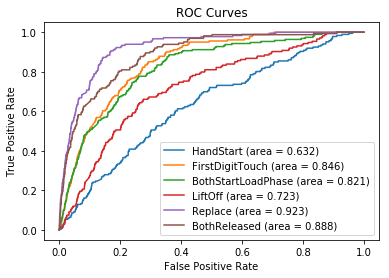

Test subject 10, class HandStart
Test subject 10, class FirstDigitTouch
Test subject 10, class BothStartLoadPhase
Test subject 10, class LiftOff
Test subject 10, class Replace
Test subject 10, class BothReleased
HandStart AUC score = 0.575
FirstDigitTouch AUC score = 0.832
BothStartLoadPhase AUC score = 0.781
LiftOff AUC score = 0.772
Replace AUC score = 0.847
BothReleased AUC score = 0.842


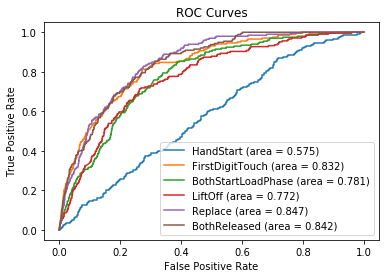

Test subject 11, class HandStart
Test subject 11, class FirstDigitTouch
Test subject 11, class BothStartLoadPhase
Test subject 11, class LiftOff
Test subject 11, class Replace
Test subject 11, class BothReleased
HandStart AUC score = 0.600
FirstDigitTouch AUC score = 0.642
BothStartLoadPhase AUC score = 0.628
LiftOff AUC score = 0.653
Replace AUC score = 0.832
BothReleased AUC score = 0.816


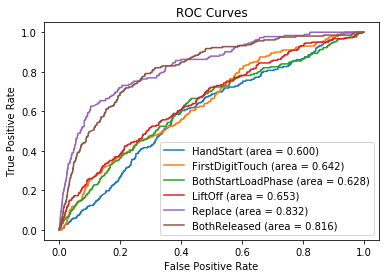

Test subject 12, class HandStart
Test subject 12, class FirstDigitTouch
Test subject 12, class BothStartLoadPhase
Test subject 12, class LiftOff
Test subject 12, class Replace
Test subject 12, class BothReleased
HandStart AUC score = 0.567
FirstDigitTouch AUC score = 0.592
BothStartLoadPhase AUC score = 0.632
LiftOff AUC score = 0.641
Replace AUC score = 0.722
BothReleased AUC score = 0.761


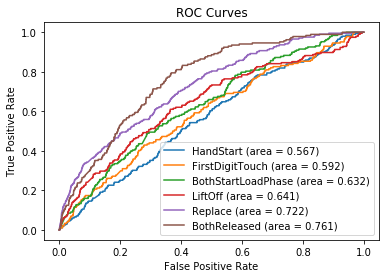

In [20]:


for subject in TEST_SUBJECTS:
    prediction_total = []
    test_data_total = []
    test_features_raw = []
    train_data_paths = glob(TRAIN_DATA_PATH % (subject))

    
    x_raw, y_raw = read_training_data(train_data_paths)
    
    x_raw, _ = preprocess_data(x_raw, WINDOW_SIZE, SUBSAMPLE)

    _, x_test, _, y_test = train_test_split(x_raw, y_raw[::SUBSAMPLE], test_size=0.5)

    
    for i in range(N_LABELS):

        test_labels = to_categorical(y_test[:,i], num_classes = None)
                
        print('Test subject %d, class %s' % (subject, COLUMNS[i]))                
        predictions = predict_on_sub(x_test, models[i], SPLIT_SIZE, BATCH_SIZE)
        
        test_data_total.append(y_test[:,i][1000::BATCH_SIZE])
        prediction_total.append(predictions)
        
    multiple_metric_auc_score(prediction_total, test_data_total, True)